# CONNECTOME ANALYSIS OF TASTE PATHWAYS

## This code reproduces the analyses in Walker et al.

### Import packages and set default plotting parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [2]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 100}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* *csv.gz files as well as *_new.csv files identifying GRNs must be in same folder as this script. These include 4 csv files containing GRN lists and 4 connectome datasets from FlyWire called "classification", "connections", "neuropil_synapse_table", and "neurons". 
* GRN lists were curated manually as described in the paper. 
* Connectome datasets were downloaded from the FlyWire website using snapshot 630.
* Note that Ir94e neurons are called "low salt" neurons in this script but not in the paper, as the study by Guillemin et al. (2024) revealed that Ir94e neurons respond to other tastants as well.

In [3]:
# Connections dataset and additional data sets

# Load the connections dataset
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type
connections = pd.read_csv('connections_630.csv.gz')

# Neuropil synapses
# columns: root_id, input synapses, input partners, output synapses, output partners, etc
# Keep only root_id, input syanapses, output synapses
neuropil_synapse = pd.read_csv('neuropil_synapse_table_630.csv.gz')[['root_id','input synapses','output synapses']]

# Rename with underscores
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)

# Load classification table
# columns: root_id, flow, super_class, side, etc
# Keep only root_id and side
classification = pd.read_csv('classification_630.csv.gz')[['root_id','side']]

# Load data about each neuron
# columns: root_id, group, nt_type, etc
# Keep only root_id, nt_type
neurons = pd.read_csv('neurons_630.csv.gz')[['root_id','nt_type']]

# Merging additional data in one data set
neurons_data = pd.merge(neurons, pd.merge(classification, neuropil_synapse, on='root_id',how= 'outer'), on='root_id',how='outer')

# Load GRN lists
# Should have 22 sugar GRNs, 18 water GRNs, 20 bitter GRNs, 9 Ir94e GRNs
sugar_GRNs = pd.read_csv('sugar_GRNs_new.csv')
water_GRNs = pd.read_csv('water_GRNs_new.csv')
bitter_GRNs = pd.read_csv('bitter_GRNs_new.csv')
lowsalt_GRNs = pd.read_csv('lowsalt_GRNs_new.csv')

### Find downstream connections of GRNs
- includes all neurons downstream of taste GRNs - we will filter out GRN-GRN connections later
- minimum of 5 synapses between the two neurons

In [4]:
# Define function to get GRN outputs
def neuronal_outputs(taste_neurons):        
        connectivity = pd.merge(taste_neurons['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
        connectivity = connectivity.drop(columns = 'root_id')
        
        # Function to get location of connection
        def projection(neuropil):
                if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R','CAN']: #these are areas within the SEZ
                        return 'local'
                else: 
                        return 'outside_SEZ'
        connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)
        return connectivity

In [5]:
# Get the outputs of each type of GRNs
sugarGRN_outputs = neuronal_outputs(sugar_GRNs)
waterGRN_outputs = neuronal_outputs(water_GRNs)
bitterGRN_outputs = neuronal_outputs(bitter_GRNs)
lowsaltGRN_outputs = neuronal_outputs(lowsalt_GRNs)

### Quantifying GRN to GRN communication
- Creates a heatmap showing number of synapses between GRNs of each type.

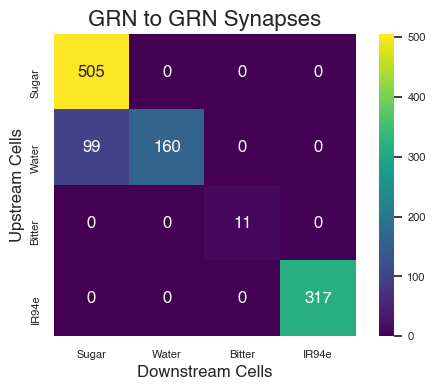

In [6]:
# Define the function
def GRN_heatmap(tasteGRN_outputs):
    df = [sugar_GRNs, water_GRNs, bitter_GRNs, lowsalt_GRNs]
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(tasteGRN_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

# calculate number of synapses between each set of GRNs
heatmap_GRNs = [GRN_heatmap(sugarGRN_outputs), GRN_heatmap(waterGRN_outputs), GRN_heatmap(bitterGRN_outputs), GRN_heatmap(lowsaltGRN_outputs)]

# Heatmap labels - this must match the order in the code above
row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

# Make heatmap (use 'fmt="d"' to display integer values, use vmin to set colorbar to start at 0)
sns.heatmap(heatmap_GRNs, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0)  

plt.title("GRN to GRN Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

## 2. SECOND ORDER NEURON ANALYSES

## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
- neuron must be downstream of taste GRN
- minimum of 5 synapses between the two neurons
- we will filter out GRNs from the list later

In [7]:
# Define function
def second_order(taste_GRNs, taste):
        
        # Get connectivity from GRNs
        connectivity = pd.merge(taste_GRNs['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
        connectivity = connectivity.drop(columns = 'root_id')
        
        # Aggregate this connectivity to get 2Ns
        second_orders = connectivity.groupby("post_root_id").agg({'pre_root_id' : 'nunique', 'syn_count' : 'sum'}).reset_index()
        second_orders.columns = ['root_id','upstream_' + taste + '_GRNs', taste + '_syn_count']
        second_orders['const'] = 1 # this will be needed for the OLS regression later
        
        return connectivity, second_orders

In [8]:
# Run function to get GRN-2N connectivity and list of 2Ns
sugar_second_order_connectivity, sugar_2Ns = second_order(sugar_GRNs, 'sugar')
water_second_order_connectivity, water_2Ns = second_order(water_GRNs, 'water')
bitter_second_order_connectivity, bitter_2Ns = second_order(bitter_GRNs, 'bitter')
lowsalt_second_order_connectivity, lowsalt_2Ns = second_order(lowsalt_GRNs, 'lowsalt')

In [9]:
# Take a look at sugar 2Ns as an example
sugar_2Ns

,root_id,upstream_sugar_GRNs,sugar_syn_count,const
0,720575940606866377,9,87,1
1,720575940610584945,1,11,1
2,720575940610916465,3,32,1
3,720575940611015122,11,118,1
4,720575940611149922,1,5,1
...,...,...,...,...
89,720575940647033396,3,33,1
90,720575940647561524,1,7,1
91,720575940655011489,3,17,1
92,720575940655013025,1,7,1


In [10]:
# Checking how many 2Ns we have - note that these do not exclude GRNs yet
print(np.unique(sugar_2Ns.root_id.values).shape)
print(np.unique(water_2Ns.root_id.values).shape)
print(np.unique(bitter_2Ns.root_id.values).shape)
print(np.unique(lowsalt_2Ns.root_id.values).shape)

(94,)
(66,)
(65,)
(33,)


### Getting more information about 2Ns from flywire

In [11]:
# Select and merge rows from neurons_data for each set of 2Ns
# This is the first time we use `neurons_data`, which is information about each neuron loaded in the first cell
# columns to join: nt_type, side, input_synapses, output_synapses
sugar_2Ns = pd.merge(sugar_2Ns, neurons_data, on = 'root_id', how = 'inner')
water_2Ns = pd.merge(water_2Ns, neurons_data, on = 'root_id', how = 'inner')
bitter_2Ns = pd.merge(bitter_2Ns, neurons_data, on = 'root_id', how = 'inner')
lowsalt_2Ns = pd.merge(lowsalt_2Ns, neurons_data, on = 'root_id', how = 'inner')

In [12]:
# Checking that we didn't drop neurons with the merge
print(np.unique(sugar_2Ns.root_id.values).shape)
print(np.unique(water_2Ns.root_id.values).shape)
print(np.unique(bitter_2Ns.root_id.values).shape)
print(np.unique(lowsalt_2Ns.root_id.values).shape)

(94,)
(66,)
(65,)
(33,)


### Remove GRNs from 2N lists

In [13]:
# Concatenate all GRNs into a single DataFrame
all_GRNs = pd.concat([sugar_GRNs, water_GRNs,bitter_GRNs,lowsalt_GRNs], axis=0)

# Drop 2Ns that are actually GRNs
sugar_2Ns = sugar_2Ns[~sugar_2Ns['root_id'].isin(all_GRNs['root_id'])]
water_2Ns = water_2Ns[~water_2Ns['root_id'].isin(all_GRNs['root_id'])]
bitter_2Ns = bitter_2Ns[~bitter_2Ns['root_id'].isin(all_GRNs['root_id'])]
lowsalt_2Ns = lowsalt_2Ns[~lowsalt_2Ns['root_id'].isin(all_GRNs['root_id'])]

# Drop all GRN output projections that are onto GRNs
sugar_second_order_connectivity = sugar_second_order_connectivity [~sugar_second_order_connectivity ['post_root_id'].isin(all_GRNs['root_id'])]
water_second_order_connectivity = water_second_order_connectivity [~water_second_order_connectivity ['post_root_id'].isin(all_GRNs['root_id'])]
bitter_second_order_connectivity = bitter_second_order_connectivity [~bitter_second_order_connectivity ['post_root_id'].isin(all_GRNs['root_id'])]
lowsalt_second_order_connectivity = lowsalt_second_order_connectivity [~lowsalt_second_order_connectivity ['post_root_id'].isin(all_GRNs['root_id'])]

In [14]:
#Check how many 2Ns are left for each modality
print(np.unique(sugar_2Ns.root_id.values).shape)
print(np.unique(water_2Ns.root_id.values).shape)
print(np.unique(bitter_2Ns.root_id.values).shape)
print(np.unique(lowsalt_2Ns.root_id.values).shape)

(76,)
(51,)
(64,)
(24,)


### Add the data from the model simulations to the 2N dataframes

This will be necessary to analyze activated vs. non-activated 2Ns.

First, import the data and add the activation status 

In [15]:
rates= [25,50,75,100,125,150,175,200] # these are the different GRN stimulation rates for the simulations

for i in rates:
    ids_activated = pd.read_csv('simulation/sugarGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    sugar_2Ns['activation_'+str(i)+'Hz'] = sugar_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    sugar_2Ns['label'] = 'sugar'
    
for i in rates:
    ids_activated = pd.read_csv('simulation/waterGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    water_2Ns['activation_'+str(i)+'Hz'] = water_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    water_2Ns['label'] = 'water'
    
for i in rates:
    ids_activated = pd.read_csv( 'simulation/bitterGRN_' + str(i) + 'Hz_rates.csv')['flyid'].values
    bitter_2Ns['activation_'+str(i)+'Hz'] = bitter_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    bitter_2Ns['label'] = 'bitter'
    
for i in rates:
    ids_activated = pd.read_csv('simulation/IR94eGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    lowsalt_2Ns['activation_'+str(i)+'Hz'] = lowsalt_2Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    lowsalt_2Ns['label'] = 'low salt'

In [16]:
# Make a dataframe with data for all modalities 
all_2N = pd.concat([sugar_2Ns,water_2Ns,bitter_2Ns,lowsalt_2Ns])
cols_merge_syn_GRN_input = ['sugar_syn_count', "water_syn_count", "bitter_syn_count","lowsalt_syn_count"]
all_2N =all_2N.assign(GRN_syn_count=all_2N[cols_merge_syn_GRN_input].sum(1)).drop(cols_merge_syn_GRN_input, axis=1)
cols_2_merge_upstream_GRN = ['upstream_sugar_GRNs', "upstream_water_GRNs", "upstream_bitter_GRNs","upstream_lowsalt_GRNs"]
all_2N  =all_2N.assign(upstream_GRN=all_2N[cols_2_merge_upstream_GRN].sum(1)).drop(cols_2_merge_upstream_GRN, axis=1)

In [17]:
# Inspecting the new data frame
all_2N

,root_id,const,nt_type,side,input_synapses,output_synapses,activation_25Hz,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,GRN_syn_count,upstream_GRN
0,720575940606866377,1,GABA,right,1483.0,1642.0,activated,sugar,activated,activated,activated,activated,activated,activated,activated,87.0,9.0
1,720575940610584945,1,ACH,right,764.0,957.0,non activated,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,11.0,1.0
2,720575940610916465,1,GABA,right,2005.0,844.0,non activated,sugar,activated,activated,activated,activated,activated,activated,activated,32.0,3.0
3,720575940611015122,1,ACH,right,918.0,267.0,non activated,sugar,activated,activated,activated,activated,activated,activated,activated,118.0,11.0
4,720575940611149922,1,GLUT,left,2884.0,1079.0,non activated,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,720575940633198284,1,ACH,left,1095.0,1009.0,non activated,low salt,non activated,non activated,non activated,non activated,non activated,non activated,non activated,6.0,1.0
28,720575940634090777,1,GABA,right,620.0,1412.0,non activated,low salt,non activated,non activated,non activated,activated,activated,activated,activated,13.0,2.0
29,720575940635642725,1,GABA,left,392.0,295.0,non activated,low salt,non activated,non activated,non activated,non activated,activated,activated,activated,6.0,1.0
30,720575940637956698,1,ACH,left,981.0,820.0,non activated,low salt,activated,activated,activated,activated,activated,activated,activated,68.0,4.0


## 2b. Quantify how many 2Ns were activated in the simulations

Note that this does not follow the order of analyses in the paper; this analysis is shown in Figure 6.

### Prepare data for plotting

In [18]:
sugar_activation_25Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_25Hz']], axis=1)
sugar_activation_25Hz['label'] = 'activation 25Hz'
sugar_activation_50Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_50Hz']], axis=1)
sugar_activation_50Hz['label'] = 'activation 50Hz'
sugar_activation_75Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_75Hz']], axis=1)
sugar_activation_75Hz['label'] = 'activation 75Hz'
sugar_activation_100Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_100Hz']], axis=1)
sugar_activation_100Hz['label'] = 'activation 100Hz'
sugar_activation_125Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_125Hz']], axis=1)
sugar_activation_125Hz['label'] = 'activation 125Hz'
sugar_activation_150Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_150Hz']], axis=1)
sugar_activation_150Hz['label'] = 'activation 150Hz'
sugar_activation_175Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_175Hz']], axis=1)
sugar_activation_175Hz['label'] = 'activation 175Hz'
sugar_activation_200Hz = pd.concat([sugar_2Ns.iloc[:,0:8], sugar_2Ns['activation_200Hz']], axis=1)
sugar_activation_200Hz['label'] = 'activation 200Hz'

sugar_activation_vertically_stacked = pd.concat([sugar_activation_25Hz,sugar_activation_50Hz,sugar_activation_75Hz,sugar_activation_100Hz,sugar_activation_125Hz,sugar_activation_150Hz,sugar_activation_175Hz,sugar_activation_200Hz], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
sugar_activation_vertically_stacked['activation'] = sugar_activation_vertically_stacked['activation_25Hz'].fillna('') + sugar_activation_vertically_stacked['activation_50Hz'].fillna('')+ sugar_activation_vertically_stacked['activation_75Hz'].fillna('')+ sugar_activation_vertically_stacked['activation_100Hz'].fillna('')+sugar_activation_vertically_stacked['activation_125Hz'].fillna('')+sugar_activation_vertically_stacked['activation_150Hz'].fillna('')+sugar_activation_vertically_stacked['activation_175Hz'].fillna('')+sugar_activation_vertically_stacked['activation_200Hz'].fillna('')

In [19]:
water_activation_25Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_25Hz']], axis=1)
water_activation_25Hz['label'] = 'activation 25Hz'
water_activation_50Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_50Hz']], axis=1)
water_activation_50Hz['label'] = 'activation 50Hz'
water_activation_75Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_75Hz']], axis=1)
water_activation_75Hz['label'] = 'activation 75Hz'
water_activation_100Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_100Hz']], axis=1)
water_activation_100Hz['label'] = 'activation 100Hz'
water_activation_125Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_125Hz']], axis=1)
water_activation_125Hz['label'] = 'activation 125Hz'
water_activation_150Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_150Hz']], axis=1)
water_activation_150Hz['label'] = 'activation 150Hz'
water_activation_175Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_175Hz']], axis=1)
water_activation_175Hz['label'] = 'activation 175Hz'
water_activation_200Hz = pd.concat([water_2Ns.iloc[:,0:8], water_2Ns['activation_200Hz']], axis=1)
water_activation_200Hz['label'] = 'activation 200Hz'

water_activation_vertically_stacked = pd.concat([water_activation_25Hz,water_activation_50Hz,water_activation_75Hz,water_activation_100Hz,water_activation_125Hz,water_activation_150Hz,water_activation_175Hz,water_activation_200Hz], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
water_activation_vertically_stacked['activation'] = water_activation_vertically_stacked['activation_25Hz'].fillna('') + water_activation_vertically_stacked['activation_50Hz'].fillna('')+ water_activation_vertically_stacked['activation_75Hz'].fillna('')+ water_activation_vertically_stacked['activation_100Hz'].fillna('')+water_activation_vertically_stacked['activation_125Hz'].fillna('')+water_activation_vertically_stacked['activation_150Hz'].fillna('')+water_activation_vertically_stacked['activation_175Hz'].fillna('')+water_activation_vertically_stacked['activation_200Hz'].fillna('')

In [20]:
bitter_activation_25Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_25Hz']], axis=1)
bitter_activation_25Hz['label'] = 'activation 25Hz'
bitter_activation_50Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_50Hz']], axis=1)
bitter_activation_50Hz['label'] = 'activation 50Hz'
bitter_activation_75Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_75Hz']], axis=1)
bitter_activation_75Hz['label'] = 'activation 75Hz'
bitter_activation_100Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_100Hz']], axis=1)
bitter_activation_100Hz['label'] = 'activation 100Hz'
bitter_activation_125Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_125Hz']], axis=1)
bitter_activation_125Hz['label'] = 'activation 125Hz'
bitter_activation_150Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_150Hz']], axis=1)
bitter_activation_150Hz['label'] = 'activation 150Hz'
bitter_activation_175Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_175Hz']], axis=1)
bitter_activation_175Hz['label'] = 'activation 175Hz'
bitter_activation_200Hz = pd.concat([bitter_2Ns.iloc[:,0:8], bitter_2Ns['activation_200Hz']], axis=1)
bitter_activation_200Hz['label'] = 'activation 200Hz'

bitter_activation_vertically_stacked = pd.concat([bitter_activation_25Hz,bitter_activation_50Hz,bitter_activation_75Hz,bitter_activation_100Hz,bitter_activation_125Hz,bitter_activation_150Hz,bitter_activation_175Hz,bitter_activation_200Hz], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
bitter_activation_vertically_stacked['activation'] = bitter_activation_vertically_stacked['activation_25Hz'].fillna('') + bitter_activation_vertically_stacked['activation_50Hz'].fillna('')+ bitter_activation_vertically_stacked['activation_75Hz'].fillna('')+ bitter_activation_vertically_stacked['activation_100Hz'].fillna('')+bitter_activation_vertically_stacked['activation_125Hz'].fillna('')+bitter_activation_vertically_stacked['activation_150Hz'].fillna('')+bitter_activation_vertically_stacked['activation_175Hz'].fillna('')+bitter_activation_vertically_stacked['activation_200Hz'].fillna('')

In [21]:
lowsalt_activation_25Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_25Hz']], axis=1)
lowsalt_activation_25Hz['label'] = 'activation 25Hz'
lowsalt_activation_50Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_50Hz']], axis=1)
lowsalt_activation_50Hz['label'] = 'activation 50Hz'
lowsalt_activation_75Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_75Hz']], axis=1)
lowsalt_activation_75Hz['label'] = 'activation 75Hz'
lowsalt_activation_100Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_100Hz']], axis=1)
lowsalt_activation_100Hz['label'] = 'activation 100Hz'
lowsalt_activation_125Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_125Hz']], axis=1)
lowsalt_activation_125Hz['label'] = 'activation 125Hz'
lowsalt_activation_150Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_150Hz']], axis=1)
lowsalt_activation_150Hz['label'] = 'activation 150Hz'
lowsalt_activation_175Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_175Hz']], axis=1)
lowsalt_activation_175Hz['label'] = 'activation 175Hz'
lowsalt_activation_200Hz = pd.concat([lowsalt_2Ns.iloc[:,0:8], lowsalt_2Ns['activation_200Hz']], axis=1)
lowsalt_activation_200Hz['label'] = 'activation 200Hz'

lowsalt_activation_vertically_stacked = pd.concat([lowsalt_activation_25Hz,lowsalt_activation_50Hz,lowsalt_activation_75Hz,lowsalt_activation_100Hz,lowsalt_activation_125Hz,lowsalt_activation_150Hz,lowsalt_activation_175Hz,lowsalt_activation_200Hz], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
lowsalt_activation_vertically_stacked['activation'] = lowsalt_activation_vertically_stacked['activation_25Hz'].fillna('') + lowsalt_activation_vertically_stacked['activation_50Hz'].fillna('')+ lowsalt_activation_vertically_stacked['activation_75Hz'].fillna('')+ lowsalt_activation_vertically_stacked['activation_100Hz'].fillna('')+lowsalt_activation_vertically_stacked['activation_125Hz'].fillna('')+lowsalt_activation_vertically_stacked['activation_150Hz'].fillna('')+lowsalt_activation_vertically_stacked['activation_175Hz'].fillna('')+lowsalt_activation_vertically_stacked['activation_200Hz'].fillna('')

In [22]:
# inspect dataframe (sugar as an example)
sugar_activation_vertically_stacked

,root_id,upstream_sugar_GRNs,sugar_syn_count,const,nt_type,side,input_synapses,output_synapses,activation_25Hz,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,activation
0,720575940606866377,9,87,1,GABA,right,1483.0,1642.0,activated,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,activated
1,720575940610584945,1,11,1,ACH,right,764.0,957.0,non activated,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
2,720575940610916465,3,32,1,GABA,right,2005.0,844.0,non activated,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
3,720575940611015122,11,118,1,ACH,right,918.0,267.0,non activated,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
4,720575940611149922,1,5,1,GLUT,left,2884.0,1079.0,non activated,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,720575940647033396,3,33,1,GABA,right,1836.0,690.0,NaN,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,activated,activated
90,720575940647561524,1,7,1,ACH,left,165.0,75.0,NaN,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,non activated,non activated
91,720575940655011489,3,17,1,ACH,left,2220.0,1362.0,NaN,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,activated,activated
92,720575940655013025,1,7,1,ACH,left,868.0,862.0,NaN,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,activated,activated


### Get basic stats on how many overall neurons and 2Ns were activated

First prepare the data by counting the number of neurons activated.

In [23]:
sugar_df_activation = pd.concat([pd.DataFrame(sugar_activation_25Hz.activation_25Hz.value_counts()),
           pd.DataFrame(sugar_activation_50Hz.activation_50Hz.value_counts()),
           pd.DataFrame(sugar_activation_75Hz.activation_75Hz.value_counts()),
           pd.DataFrame(sugar_activation_100Hz.activation_100Hz.value_counts()),
           pd.DataFrame(sugar_activation_125Hz.activation_125Hz.value_counts()),
           pd.DataFrame(sugar_activation_150Hz.activation_150Hz.value_counts()),
           pd.DataFrame(sugar_activation_175Hz.activation_175Hz.value_counts()),
           pd.DataFrame(sugar_activation_200Hz.activation_200Hz.value_counts())]
          , axis = 1)

water_df_activation = pd.concat([pd.DataFrame(water_activation_25Hz.activation_25Hz.value_counts()),
           pd.DataFrame(water_activation_50Hz.activation_50Hz.value_counts()),
           pd.DataFrame(water_activation_75Hz.activation_75Hz.value_counts()),
           pd.DataFrame(water_activation_100Hz.activation_100Hz.value_counts()),
           pd.DataFrame(water_activation_125Hz.activation_125Hz.value_counts()),
           pd.DataFrame(water_activation_150Hz.activation_150Hz.value_counts()),
           pd.DataFrame(water_activation_175Hz.activation_175Hz.value_counts()),
           pd.DataFrame(water_activation_200Hz.activation_200Hz.value_counts())]
          , axis = 1)

bitter_df_activation = pd.concat([pd.DataFrame(bitter_activation_25Hz.activation_25Hz.value_counts()),
           pd.DataFrame(bitter_activation_50Hz.activation_50Hz.value_counts()),
           pd.DataFrame(bitter_activation_75Hz.activation_75Hz.value_counts()),
           pd.DataFrame(bitter_activation_100Hz.activation_100Hz.value_counts()),
           pd.DataFrame(bitter_activation_125Hz.activation_125Hz.value_counts()),
           pd.DataFrame(bitter_activation_150Hz.activation_150Hz.value_counts()),
           pd.DataFrame(bitter_activation_175Hz.activation_175Hz.value_counts()),
           pd.DataFrame(bitter_activation_200Hz.activation_200Hz.value_counts())]
          , axis = 1)

lowsalt_df_activation = pd.concat([pd.DataFrame(lowsalt_activation_25Hz.activation_25Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_50Hz.activation_50Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_75Hz.activation_75Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_100Hz.activation_100Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_125Hz.activation_125Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_150Hz.activation_150Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_175Hz.activation_175Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_200Hz.activation_200Hz.value_counts())]
          , axis = 1)

### Plot how many 2Ns were activated by GRN stimulation

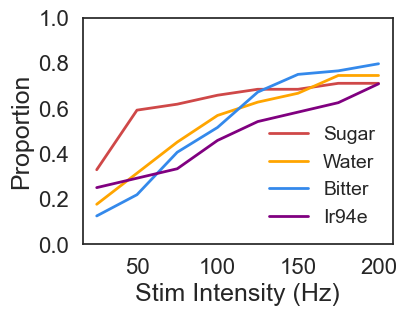

In [24]:
input_intensity = [25,50,75,100,125,150,175,200]

y_sugar = sugar_df_activation.values[1,:] / (sugar_df_activation.values[0,:]+ sugar_df_activation.values[1,:] )
y_water = water_df_activation.values[1,:] / (water_df_activation.values[0,:]+ water_df_activation.values[1,:] )
y_bitter = bitter_df_activation.values[1,:] / (bitter_df_activation.values[0,:]+ bitter_df_activation.values[1,:])
y_lowsalt = lowsalt_df_activation.values[1,:] / (lowsalt_df_activation.values[0,:]+ lowsalt_df_activation.values[1,:])

y_modalities = [y_sugar, y_water, y_bitter, y_lowsalt] 

labels = ["Sugar", "Water", "Bitter","Ir94e"]

sns.set(style="white")
fig, ax = plt.subplots(figsize=(4, 3))

# Define color palette
colors = ['#cf4848', 'orange', '#3489eb','purple']

# Plot each of the main lines
for i, label in enumerate(labels):
    # Line
    ax.plot(input_intensity , y_modalities[i], label=label, color=colors[i], linewidth=2)

ax.set_xlabel("Stim Intensity (Hz)", size=18)
ax.set_ylabel("Proportion", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(frameon=False, fontsize=14)
ax.set_yticks(np.arange(0, 1.1, step=0.2))
#plt.title("Proportion of 2Ns activated")
plt.show()

In [25]:
# get numbers for proportion of activated 2Ns
print(y_sugar)
print(y_water)
print(y_bitter)
print(y_lowsalt)

[0.32894737 0.59210526 0.61842105 0.65789474 0.68421053 0.68421053
 0.71052632 0.71052632]
[0.17647059 0.31372549 0.45098039 0.56862745 0.62745098 0.66666667
 0.74509804 0.74509804]
[0.125    0.21875  0.40625  0.515625 0.671875 0.75     0.765625 0.796875]
[0.25       0.29166667 0.33333333 0.45833333 0.54166667 0.58333333
 0.625      0.70833333]


### Plot how many neurons in the entire brain were activated by GRN stimulation

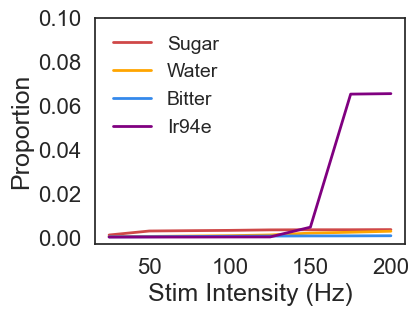

In [26]:
input_intensity = [25,50,75,100,125,150,175,200]

sugar_total_activation = []
water_total_activation = []
bitter_total_activation = []
lowsalt_total_activation = []
for i in input_intensity:
    sugar_total_activation.append(pd.read_csv('simulation/sugarGRN_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])
    water_total_activation.append(pd.read_csv('simulation/waterGRN_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])
    bitter_total_activation.append(pd.read_csv('simulation/bitterGRN_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])
    lowsalt_total_activation.append(pd.read_csv('simulation/IR94eGRN_'+str(i)+'Hz_rates.csv')['flyid'].values.shape[0]/np.unique(neurons.root_id.values).shape[0])

y_total_modality = [sugar_total_activation,water_total_activation,bitter_total_activation,lowsalt_total_activation]

labels_total = ["Sugar", "Water", "Bitter","Ir94e"]

fig, ax = plt.subplots(figsize=(4, 3))

# Define color palette
colors = ['#cf4848', 'orange', '#3489eb','purple']

# Plot each of the main lines
for i, label in enumerate(labels_total):
    # Line
    ax.plot(input_intensity , y_total_modality [i], label=label, color=colors[i], linewidth=2)

ax.set_xlabel("Stim Intensity (Hz)", size=18)
ax.set_ylabel("Proportion", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_yticks(np.arange(0, 0.12, step=0.02)) # zoomed in view to show the data better
#ax.set_yticks(np.arange(0, 1.1, step=0.2)) # same scale as 2N activation plot - can't really see anything
ax.legend(frameon=False, fontsize=14)
#plt.title("Proportion of all neurons activated")
plt.show()

In [27]:
# get numbers for proportion of activated neurons
print(sugar_total_activation)
print(water_total_activation)
print(bitter_total_activation)
print(lowsalt_total_activation)

[0.0010626826485802248, 0.0028833080685742862, 0.0030395849286596133, 0.0031724202597321416, 0.003399021706855866, 0.00345371860788573, 0.0034615324508899966, 0.0035240431949241278]
[0.00028911219115785523, 0.000414133679226117, 0.0005938520683242433, 0.0007579427714138367, 0.0010783103345887574, 0.0019222053790495242, 0.0023207113722671082, 0.0027817281095188235]
[0.00021878760411945804, 0.0002812983481535889, 0.00038287830720905156, 0.00048445826626451424, 0.0005782243823157105, 0.0006407351263498414, 0.0006641766553626405, 0.000718873556392505]
[0.00011720764506399537, 0.00012502148806826173, 0.0001328353310725281, 0.00016409070308959353, 0.00017971838909812624, 0.004625795058525684, 0.06522214755661129, 0.06544093516073075]


### Print out the median synapse values for activated vs. non-activated neurons in each modality

In [28]:
# look at median synapse values for sugar
sugar_activation_vertically_stacked.groupby(['label','activation'])['sugar_syn_count'].median()

label             activation   
activation 100Hz  activated         42.5
                  non activated      7.0
activation 125Hz  activated         39.0
                  non activated      7.0
activation 150Hz  activated         39.0
                  non activated      7.0
activation 175Hz  activated         39.0
                  non activated      6.5
activation 200Hz  activated         39.0
                  non activated      6.5
activation 25Hz   activated        112.0
                  non activated     11.0
activation 50Hz   activated         48.0
                  non activated      8.0
activation 75Hz   activated         47.0
                  non activated      8.0
Name: sugar_syn_count, dtype: float64

In [29]:
# look at median synapse values for water
water_activation_vertically_stacked.groupby(['label','activation'])['water_syn_count'].median()

label             activation   
activation 100Hz  activated         34.0
                  non activated      6.0
activation 125Hz  activated         26.5
                  non activated      6.0
activation 150Hz  activated         26.5
                  non activated      6.0
activation 175Hz  activated         23.0
                  non activated      6.0
activation 200Hz  activated         23.0
                  non activated      6.0
activation 25Hz   activated        147.0
                  non activated     10.0
activation 50Hz   activated         88.0
                  non activated      7.0
activation 75Hz   activated         49.0
                  non activated      6.0
Name: water_syn_count, dtype: float64

In [30]:
# look at median synapse values for bitter
bitter_activation_vertically_stacked.groupby(['label','activation'])['bitter_syn_count'].median()

label             activation   
activation 100Hz  activated         37.0
                  non activated     10.0
activation 125Hz  activated         31.0
                  non activated      7.0
activation 150Hz  activated         26.5
                  non activated      8.5
activation 175Hz  activated         25.0
                  non activated      7.0
activation 200Hz  activated         22.0
                  non activated      7.0
activation 25Hz   activated        111.5
                  non activated     15.5
activation 50Hz   activated         84.5
                  non activated     12.0
activation 75Hz   activated         40.5
                  non activated     11.0
Name: bitter_syn_count, dtype: float64

In [31]:
# look at median synapse values for IR94e
lowsalt_activation_vertically_stacked.groupby(['label','activation'])['lowsalt_syn_count'].median()

label             activation   
activation 100Hz  activated        148.0
                  non activated      6.0
activation 125Hz  activated         68.0
                  non activated      6.0
activation 150Hz  activated         52.0
                  non activated      6.0
activation 175Hz  activated         36.0
                  non activated      6.0
activation 200Hz  activated         26.0
                  non activated      6.0
activation 25Hz   activated        261.0
                  non activated     11.5
activation 50Hz   activated        221.0
                  non activated     11.0
activation 75Hz   activated        189.5
                  non activated      9.0
Name: lowsalt_syn_count, dtype: float64

### Make boxplots of activation vs. synapse count for each modality

For each modality and each stimulation rate, we are separating the 2Ns into 2 groups: those that were activated and those that weren't. We are then plotting the median number of input GRN synapses for each of those groups. 

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

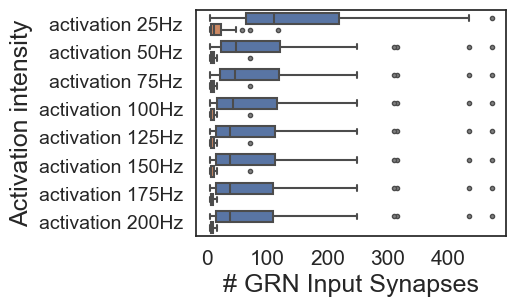

In [32]:
# sugar
plt.subplots(figsize = (4,3))
sns.set(style="white")
ax = sns.boxplot(data=sugar_activation_vertically_stacked, 
                 x="sugar_syn_count", 
                 y = 'label', 
                 hue="activation",
                 hue_order = ['activated', 'non activated'],
                 flierprops={"marker": "o", 'markersize': 3, 'markerfacecolor': 'grey'}
                )
ax.get_legend().set_visible(False)
ax.set_xlabel('# GRN Input Synapses', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

#plt.yticklabels(['25 Hz','50 Hz','75 Hz', '100 Hz', '125 Hz', '150 Hz', '175 Hz', '200 Hz'], fontsize=16)
#ax.set_xticks(fontsize=16)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

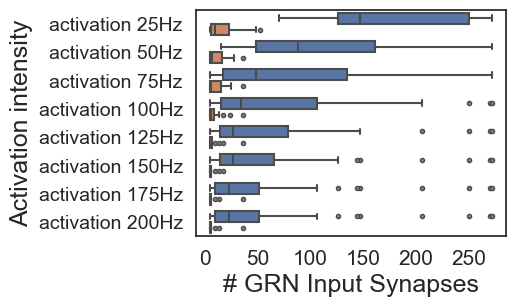

In [33]:
# water
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked, 
                 x="water_syn_count", 
                 y = 'label', 
                 hue="activation",
                 hue_order = ['activated', 'non activated'],
                 flierprops={"marker": "o", 'markersize': 3, 'markerfacecolor': 'grey'}
                )
ax.get_legend().set_visible(False)
ax.set_xlabel('# GRN Input Synapses', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

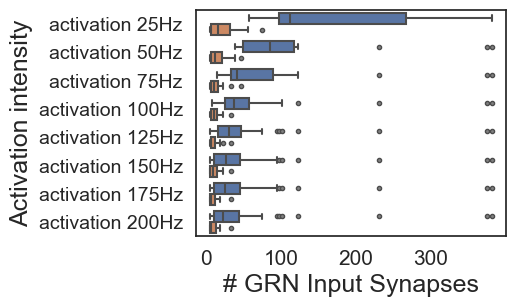

In [34]:
# bitter
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked, 
                 x="bitter_syn_count", 
                 y = 'label', 
                 hue="activation",
                 hue_order = ['activated', 'non activated'],
                 flierprops={"marker": "o", 'markersize': 3, 'markerfacecolor': 'grey'}
                )
ax.get_legend().set_visible(False)
ax.set_xlabel('# GRN Input Synapses', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

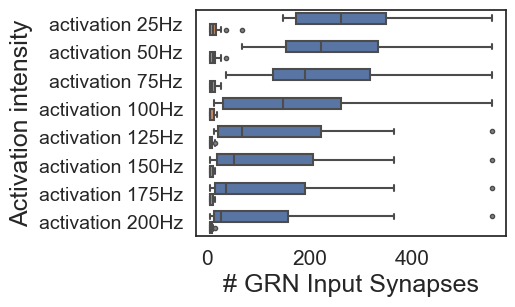

In [35]:
# low salt
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked, 
                 x="lowsalt_syn_count", 
                 y = 'label', 
                 hue="activation",
                 hue_order = ['activated', 'non activated'],
                 flierprops={"marker": "o", 'markersize': 3, 'markerfacecolor': 'grey'}
                )
ax.get_legend().set_visible(False)
ax.set_xlabel('# GRN Input Synapses', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)


## 2c. Analyze 2N inputs/outputs and convergence/interactions across modalities

Note that this section includes 2N output heatmaps that are actually shown in the 3N section of the paper.

### Make a Venn diagram to analyze convergence of different GRN modalities onto 2Ns

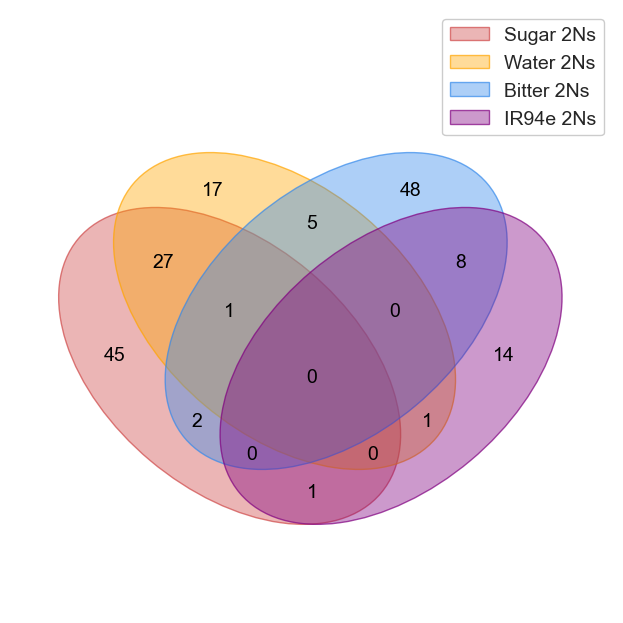

In [36]:
sugar_list = {'{}'.format(value) for value in sugar_2Ns['root_id'].unique()}
sugar_dict = {'Sugar 2Ns': sugar_list}

water_list = {'{}'.format(value) for value in water_2Ns['root_id'].unique()}
water_dict = {'Water 2Ns': water_list}

bitter_list = {'{}'.format(value) for value in bitter_2Ns['root_id'].unique()}
bitter_dict = {'Bitter 2Ns': bitter_list}

lowsalt_list = {'{}'.format(value) for value in lowsalt_2Ns['root_id'].unique()}
lowsalt_dict = {'IR94e 2Ns': lowsalt_list}

colors = ('#cf4848','orange','#3489eb','purple')
crossover = {**sugar_dict, **water_dict, **bitter_dict, **lowsalt_dict}
venn(crossover, cmap = ListedColormap(colors), figsize = (8,8), fontsize = 14)
plt.show()

### Get downstream connections of 2Ns in order to assess 2N-2N and 2N-GRN connectivity
- minimum of 5 synapses for a connection
- all connections are counted, even if they are connections to GRNs or other 2Ns

In [37]:
# Get outputs of each 2N population using the same "neuronal_outputs" function defined earlier for GRNs
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type, location_of_connection
sugar2N_outputs = neuronal_outputs(sugar_2Ns)
water2N_outputs = neuronal_outputs(water_2Ns)
bitter2N_outputs = neuronal_outputs(bitter_2Ns)
lowsalt2N_outputs = neuronal_outputs(lowsalt_2Ns)

### Plot heatmap of all 2N to 2N synapses

In [38]:
# Define function to get data for heatmaps
def _2N_heatmap(taste2N_outputs, df):
    
    taste_connectivity = []
    array = []
    for i in range(len(df)): 
        taste_connectivity.append(pd.merge(taste2N_outputs, df[i], left_on = 'post_root_id', right_on = 'root_id', how = 'inner'))
        array.append(taste_connectivity[i]['syn_count'].sum())
    return array

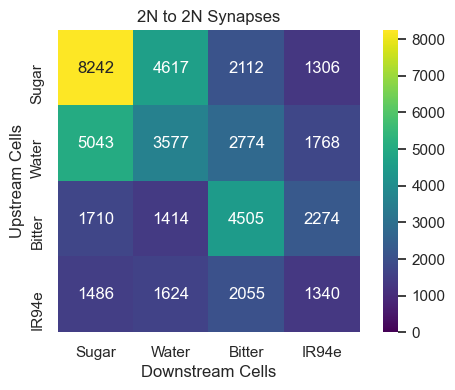

In [39]:
# Run function and plot 2N-2N synapses
df = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]
heatmap_2Ns_all = [_2N_heatmap(sugar2N_outputs, df),_2N_heatmap(water2N_outputs, df), _2N_heatmap(bitter2N_outputs, df), _2N_heatmap(lowsalt2N_outputs, df)]

row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

sns.heatmap(heatmap_2Ns_all, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0) 
plt.title("2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Plot heatmap of excitatory 2N to 2N synapses

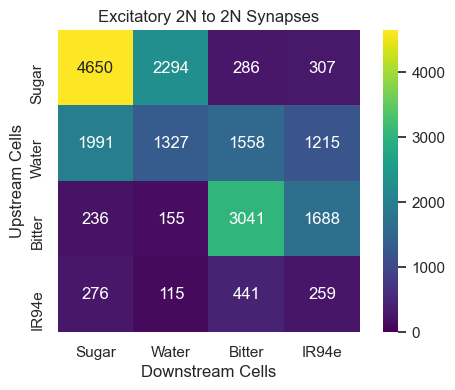

In [40]:
# First select only excitatory (Ach) synapses, then make the heatmap again
df = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]
heatmap_2Ns_exc = [_2N_heatmap(sugar2N_outputs.query("nt_type == 'ACH'"), df),_2N_heatmap(water2N_outputs.query("nt_type == 'ACH'"), df), 
               _2N_heatmap(bitter2N_outputs.query("nt_type == 'ACH'"), df), _2N_heatmap(lowsalt2N_outputs.query("nt_type == 'ACH'"), df)]

row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

sns.heatmap(heatmap_2Ns_exc, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0)  
plt.title("Excitatory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Plot heatmap of inhibitory 2N to 2N synapses

In [41]:
# First select only inhibitory (GABA/GLUT) synapses, then make the heatmap again
# Note - this cell throws an error if you have an older version of pandas, as occurred here, but should work for most users

df = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]
heatmap_2Ns_inh = [_2N_heatmap(sugar2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df), _2N_heatmap(water2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
               _2N_heatmap(bitter2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df), _2N_heatmap(lowsalt2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)]

row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

sns.heatmap(heatmap_2Ns_inh, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0)
plt.title("Inhibitory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

TypeError: 'Series' objects are mutable, thus they cannot be hashed

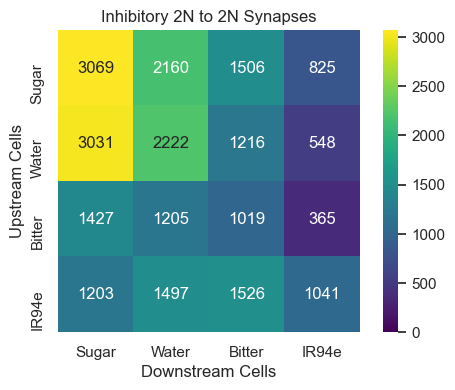

In [42]:
# manually putting in the data because of the error - pandas update is needed
heatmap_2Ns_inh = [[3069, 2160, 1506, 825],
 [3031, 2222, 1216, 548],
 [1427, 1205, 1019, 365],
 [1203, 1497, 1526, 1041]]

row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

sns.heatmap(heatmap_2Ns_inh, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0) 
plt.title("Inhibitory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

### Plot heatmap of all 2N to GRN synapses

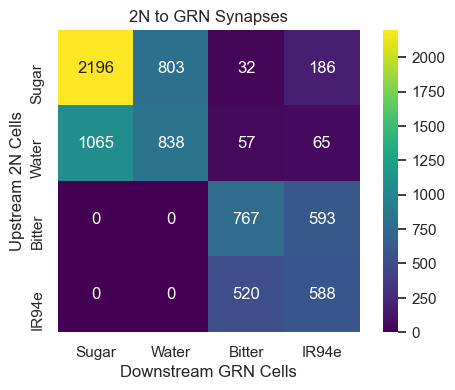

In [43]:
# Run the same function as above but now df contains GRNs, not 2Ns
df = [sugar_GRNs, water_GRNs, bitter_GRNs, lowsalt_GRNs]
heatmap_2Ns_GRNs = [_2N_heatmap(sugar2N_outputs, df),_2N_heatmap(water2N_outputs, df), _2N_heatmap(bitter2N_outputs, df), _2N_heatmap(lowsalt2N_outputs, df)]

row_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
col_labels = ['Sugar', 'Water', 'Bitter', 'IR94e']

sns.heatmap(heatmap_2Ns_GRNs, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, square=True, vmin=0) 
plt.title("2N to GRN Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream GRN Cells")
plt.show()

### Make a heatmap to see connectivity from GRNs to individual 2Ns

We will plot each individual 2N as a different column and each GRN modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of GRNs onto each 2N. 

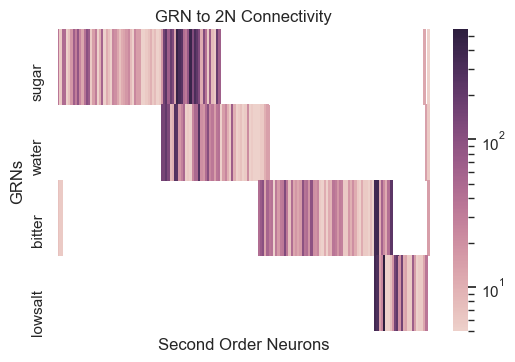

In [44]:
# concatenate connectivity data from all modalities
heatmap_data = pd.concat([sugar_second_order_connectivity, water_second_order_connectivity, bitter_second_order_connectivity, lowsalt_second_order_connectivity], axis = 0)

# group by postsynaptic neuron - this is to sort the columns later
heatmap_data['post_root_id_group'] = ' '
for entry in heatmap_data['post_root_id']:
    heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = ' '
    group = ''
    if entry in sugar_2Ns['root_id'].values:
        group += 'sugar'
    if entry in water_2Ns['root_id'].values:
        group += 'water'
    if entry in bitter_2Ns['root_id'].values:
        group += 'bitter'
    if entry in lowsalt_2Ns['root_id'].values:
        group += 'lowsalt'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group

# group by presynaptic neuron - this is to put entries in the correct row
for entry in heatmap_data['pre_root_id']:
    if entry in sugar_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'sugar'
    elif entry in water_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'water'
    elif entry in bitter_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'bitter'
    elif entry in lowsalt_GRNs['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'lowsalt'
    else:
        pass
    
# set desired order for heatmap rows and columns 
custom_order = ['sugarbitter','sugar','sugarwater','water','waterbitter','bitter','bitterlowsalt','lowsalt','sugarlowsalt','waterlowsalt']
custom_order2 = ['sugar','water','bitter','lowsalt']
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order2, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

# turn the dataframe into a matrix showing connectivity from each type of GRN
# this matrix has 169 columns corresponding to 169 unique 2Ns across all modalities
heatmap_matrix = df_sorted.pivot_table(index = 'pre_root_id_group', columns = 'post_root_id', values = 'syn_count', aggfunc='sum', fill_value = 0)
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

# plotting
sns.heatmap(heatmap_matrix, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('GRN to 2N Connectivity')
plt.xlabel('Second Order Neurons')
plt.ylabel('GRNs')
plt.show()

## 2d. Analyze 2N inputs within a modality

### First, add columns with % input coming from GRNs and average of upstream synapses from GRNs.

In [45]:
# % input to each 2N from GRNs (as a % of total input the 2N receives)
# This was used for analyses that are not included in the paper
sugar_2Ns['%_sugar_input'] = sugar_2Ns['sugar_syn_count']/sugar_2Ns['input_synapses']*100
water_2Ns['%_water_input'] = water_2Ns['water_syn_count']/water_2Ns['input_synapses']*100
bitter_2Ns['%_bitter_input'] = bitter_2Ns['bitter_syn_count']/bitter_2Ns['input_synapses']*100
lowsalt_2Ns['%_lowsalt_input'] = lowsalt_2Ns['lowsalt_syn_count']/lowsalt_2Ns['input_synapses']*100

In [46]:
# Average number of synapses each 2N receives per GRN, considering only GRNs of the same modality
# This is used in the scatter plots below
sugar_2Ns['avg_upstream_synapses'] = sugar_2Ns['sugar_syn_count']/sugar_2Ns['upstream_sugar_GRNs']
water_2Ns['avg_upstream_synapses'] = water_2Ns['water_syn_count']/water_2Ns['upstream_water_GRNs']
bitter_2Ns['avg_upstream_synapses'] = bitter_2Ns['bitter_syn_count']/bitter_2Ns['upstream_bitter_GRNs']
lowsalt_2Ns['avg_upstream_synapses'] = lowsalt_2Ns['lowsalt_syn_count']/lowsalt_2Ns['upstream_lowsalt_GRNs']

### Compare the # GRN input cells and the average # synapses per input cell for each 2N

First we will make scatter plots comparing these variables for each modality.

Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.

We will also report the median number of input synapses and input GRNs per 2N. 

In [47]:
# define a function to plot a scatter plot of # input GRNs versus # synapses per GRN
# the function also fits a line to the data
def synapse_scatter_2Ns(taste_2Ns, taste, color, title):
    
    # define x and y data
    x = taste_2Ns['upstream_' + taste + '_GRNs'].astype('int') 
    y = taste_2Ns['avg_upstream_synapses']
    
    # define line to be fit
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    
    # make plot
    fig, ax = plt.subplots(figsize = (4,3))
    sns.scatterplot(data=taste_2Ns, x='upstream_' + taste + '_GRNs', y="avg_upstream_synapses", color = color)
    x_line = np.arange(1, max(x)+1, 1)
    y_line = objective(x_line, a, b)
    
    ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x) + 2, step=2))
    ax.set_yticks(np.arange(0, max(y) + 3, step=10))
    ax.set_xlabel('# Input GRNs', size=18)
    ax.set_ylabel('# Synapses per GRN', size=18)
    #ax.set_title('Convergence Within ' + title + ' 2Ns', size=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    
    formula = ('y = %.5f * x + %.5f' % (a, b))
    
    return fig, ax, formula

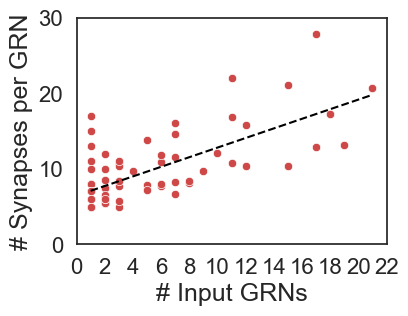

In [48]:
# Sugar
fig, ax, formula = synapse_scatter_2Ns(sugar_2Ns, 'sugar', '#cf4848', 'Sugar')

In [49]:
# OLS regression for sugar
sugar_model = sm.OLS(sugar_2Ns['avg_upstream_synapses'], sugar_2Ns[['const','upstream_sugar_GRNs']]).fit()
sugar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.494
Model:                               OLS   Adj. R-squared:                  0.487
Method:                    Least Squares   F-statistic:                     72.33
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):           1.44e-12
Time:                           14:47:56   Log-Likelihood:                -198.09
No. Observations:                     76   AIC:                             400.2
Df Residuals:                         74   BIC:                             404.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.4408      0.524     12.284      0.000       5.396       7.486
upstream_sugar_GRNs     0.6358      0.075      8.505      0.000       0.487       0.785
==============================================================================
Omnibus:                       19.846   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.211
Skew:                           1.207   Prob(JB):                     3.35e-06
Kurtosis:                       4.462   Cond. No.                         9.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(sugar_model.pvalues[1])

#median number of sugar GRNs providing input to a sugar 2N 
print(np.median(sugar_2Ns['upstream_sugar_GRNs']))

#median number of sugar GRN synapses providing input to sugar 2N 
print(np.median(sugar_2Ns['sugar_syn_count']))

1.4380896424915372e-12
2.0
17.0


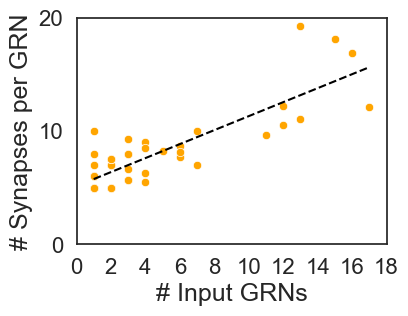

(<Figure size 400x300 with 1 Axes>,
 <AxesSubplot:xlabel='# Input GRNs', ylabel='# Synapses per GRN'>,
 'y = 0.61741 * x + 5.13682')

In [51]:
# Water
synapse_scatter_2Ns(water_2Ns, 'water', 'orange','Water')

In [52]:
# OLS regression for water
water_model = sm.OLS(water_2Ns['avg_upstream_synapses'], water_2Ns[['const','upstream_water_GRNs']]).fit()
water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.723
Model:                               OLS   Adj. R-squared:                  0.718
Method:                    Least Squares   F-statistic:                     128.2
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):           2.78e-15
Time:                           14:47:58   Log-Likelihood:                -99.538
No. Observations:                     51   AIC:                             203.1
Df Residuals:                         49   BIC:                             206.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1368      0.334     15.378      0.000       4.466       5.808
upstream_water_GRNs     0.6174      0.055     11.323      0.000       0.508       0.727
==============================================================================
Omnibus:                       15.924   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.865
Skew:                           1.093   Prob(JB):                     2.95e-05
Kurtosis:                       5.245   Cond. No.                         8.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(water_model.pvalues[1])

#median number of water GRNs providing input to a water 2N 
print(np.median(water_2Ns['upstream_water_GRNs']))

#median number of water GRN synapses providing input to water 2N 
print(np.median(water_2Ns['water_syn_count']))

2.7788333195137485e-15
2.0
15.0


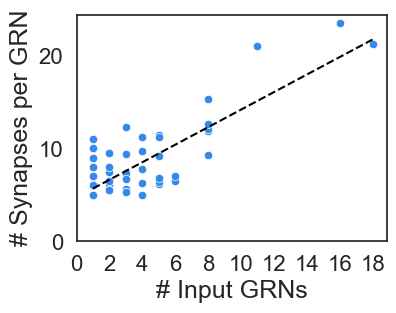

(<Figure size 400x300 with 1 Axes>,
 <AxesSubplot:xlabel='# Input GRNs', ylabel='# Synapses per GRN'>,
 'y = 0.94247 * x + 4.72590')

In [54]:
# Bitter
synapse_scatter_2Ns(bitter_2Ns, 'bitter', '#3489eb','Bitter')

In [55]:
# OLS regression for bitter
bitter_model = sm.OLS(bitter_2Ns['avg_upstream_synapses'], bitter_2Ns[['const','upstream_bitter_GRNs']]).fit()
bitter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.665
Model:                               OLS   Adj. R-squared:                  0.659
Method:                    Least Squares   F-statistic:                     122.8
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):           2.42e-16
Time:                           14:47:59   Log-Likelihood:                -141.99
No. Observations:                     64   AIC:                             288.0
Df Residuals:                         62   BIC:                             292.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.7259      0.420     11.249      0.000       3.886       5.566
upstream_bitter_GRNs     0.9425      0.085     11.083      0.000       0.772       1.112
==============================================================================
Omnibus:                        3.917   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.547
Skew:                           0.576   Prob(JB):                        0.170
Kurtosis:                       2.969   Cond. No.                         7.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(bitter_model.pvalues[1])

#median number of bitter GRNs providing input to a bitter 2N 
print(np.median(bitter_2Ns['upstream_bitter_GRNs']))

#median number of bitter GRN synapses providing input to bitter 2N 
print(np.median(bitter_2Ns['bitter_syn_count']))

2.419413233347331e-16
3.0
17.0


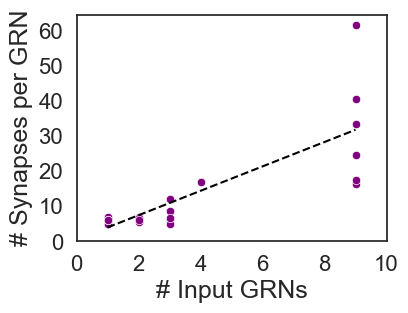

(<Figure size 400x300 with 1 Axes>,
 <AxesSubplot:xlabel='# Input GRNs', ylabel='# Synapses per GRN'>,
 'y = 3.47891 * x + 0.45551')

In [57]:
# Lowsalt
synapse_scatter_2Ns(lowsalt_2Ns, 'lowsalt', 'purple','IR94e')

In [58]:
# OLS regression for low salt
lowsalt_model = sm.OLS(lowsalt_2Ns['avg_upstream_synapses'], lowsalt_2Ns[['const','upstream_lowsalt_GRNs']]).fit()
lowsalt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.647
Model:                               OLS   Adj. R-squared:                  0.631
Method:                    Least Squares   F-statistic:                     40.38
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):           2.15e-06
Time:                           14:48:01   Log-Likelihood:                -84.368
No. Observations:                     24   AIC:                             172.7
Df Residuals:                         22   BIC:                             175.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4555      2.670      0.171      0.866      -5.083       5.994
upstream_lowsalt_GRNs     3.4789      0.547      6.354      0.000       2.344       4.614
==============================================================================
Omnibus:                       21.605   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.336
Skew:                           1.566   Prob(JB):                     1.06e-09
Kurtosis:                       8.615   Cond. No.                         7.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(lowsalt_model.pvalues[1])

#median number of Ir94e GRNs providing input to a Ir94e 2N 
print(np.median(lowsalt_2Ns['upstream_lowsalt_GRNs']))

#median number of Ir94e GRN synapses providing input to Ir94e 2N 
print(np.median(lowsalt_2Ns['lowsalt_syn_count']))

2.148539548315457e-06
2.5
14.5


### Plot distribution of GRN-2N connection strength

We are quantifying the total number of GRN input synapses that each 2N receives, and looking at the distribution across all 2Ns.

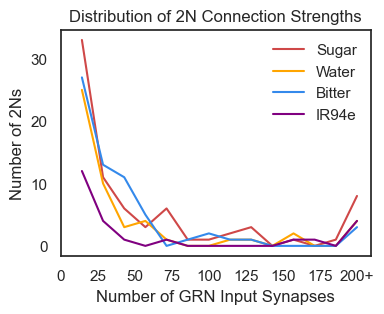

In [60]:
# define a function to get the synapse distribution
bins = np.linspace(0,200,15)
def synapse_distribution_2Ns(taste_2Ns, taste):
    data = taste_2Ns[taste + '_syn_count']
    frequencies, bin_edges = np.histogram(np.clip(data,0,200), bins) #clipping the data at 200
    bin_labels = bins[1:]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies' : frequencies})
    return df

# calculate synapse distribution for each modality
sugar_synapse_distribution = synapse_distribution_2Ns(sugar_2Ns, 'sugar')
water_synapse_distribution = synapse_distribution_2Ns(water_2Ns, 'water')
bitter_synapse_distribution = synapse_distribution_2Ns(bitter_2Ns, 'bitter')
lowsalt_synapse_distribution = synapse_distribution_2Ns(lowsalt_2Ns, 'lowsalt')

# organize data and parameters for plotting
dataframes = [sugar_synapse_distribution, water_synapse_distribution, bitter_synapse_distribution, lowsalt_synapse_distribution]
labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
colors = ['#cf4848', 'orange', '#3489eb', 'purple']

# make plot
plt.figure(figsize=(4,3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 25, 50, 75, 100, 125, 150, 175, 200]
xlabels = ['0', '25', '50', '75', '100', '125', '150', '175', '200+']
plt.xticks(xticks, xlabels)
plt.xlabel('Number of GRN Input Synapses')
plt.ylabel('Number of 2Ns')
plt.title('Distribution of 2N Connection Strengths')
plt.legend(frameon=False)
plt.show()

## 2e. Classifying 2Ns by their anatomical and functional properties

### First, we will define 2Ns as local vs. projection neurons. 
- Local neurons have output connections only in the SEZ (defined as including GNG, PRW, SAD, FLA, CAN)
- Projection neurons have at least one output connection (comprising at least 5 synapses) in another brain region

In [61]:
# Function to classify neurons as local vs. projection
def classify_neurons(neurons):
    
    # get 2Ns
    neurons_classified = pd.merge(neurons['root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                    left_on = 'root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 5")
    
    # define whether projections are only in SEZ
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R','CAN']: #these are SEZ neuropils
            return 'local'
        else: 
            return 'outside_SEZ'
    neurons_classified['location_of_connection'] = neurons_classified['neuropil'].apply(projection)
    classifications = [] 
    
    # label neurons accordingly
    for entry in neurons_classified['pre_root_id'].unique():
        if entry in neurons_classified.query("location_of_connection != 'local'")['pre_root_id'].unique():
            #Labeling as projection neuron if it is not local 
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'projection',
                                        '#_projection_synapses': neurons_classified.query(
                                                f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                                'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)
        else:
            #Labeling as local neuron if it is local 
            classification = pd.DataFrame({'root_id': [entry], 'neuron_type': 'local',
                                        '#_projection_synapses': neurons_classified.query(
                                            f"pre_root_id == {entry} & location_of_connection != 'local'")[
                                            'syn_count'].sum()}, index=[0]) 
            classifications.append(classification)

    result = pd.concat(classifications, ignore_index=True) 
    return result

In [62]:
# Run the function on each set of 2Ns
sugar_2Ns = pd.merge(sugar_2Ns, classify_neurons(sugar_2Ns), on = 'root_id')
water_2Ns = pd.merge(water_2Ns, classify_neurons(water_2Ns), on = 'root_id')
bitter_2Ns = pd.merge(bitter_2Ns, classify_neurons(bitter_2Ns), on = 'root_id')
lowsalt_2Ns = pd.merge(lowsalt_2Ns, classify_neurons(lowsalt_2Ns), on = 'root_id')

In [63]:
# Save 2N lists as csv files
sugar_2Ns.to_csv('sugar_2Ns.csv')
water_2Ns.to_csv('water_2Ns.csv')
bitter_2Ns.to_csv('bitter_2Ns.csv')
lowsalt_2Ns.to_csv('lowsalt_2Ns.csv')

### Comparing the number of local vs. projection 2Ns across modalities

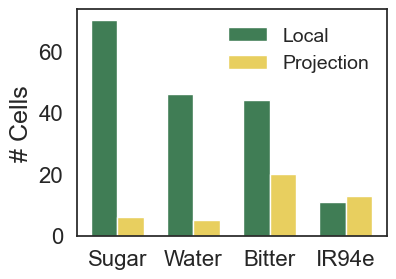

In [64]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar_2Ns, water_2Ns, bitter_2Ns, lowsalt_2Ns]

local_neurons = []
projection_neurons = []

for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))

x = range(len(categories))
bar_width = 0.35

plt.figure(figsize=(4,3))
plt.bar(x, local_neurons, width=bar_width,label = "Local", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_neurons, width=bar_width, label = "Projection", color = '#e8cf5f')

#plt.title('Classification of Second Order Neurons', size = 16)
plt.ylabel('# Cells', size=18)
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [65]:
# Show numbers of local and projection neurons
print(local_neurons)
print(projection_neurons)

[70, 46, 44, 11]
[6, 5, 20, 13]


### Comparing the number of 2N output synapses within versus outside the SEZ across modalities.

We are using the "2N_outputs" lists that were defined earlier, which could include synapses to GRNs or other 2Ns.

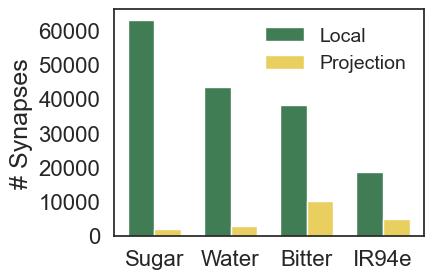

In [66]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())
    
x = range(len(categories))

bar_width = 0.35

plt.figure(figsize=(4,3))
plt.bar(x, local_synapses, width=bar_width,label = "Local", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_synapses, width=bar_width, label = "Projection", color = '#e8cf5f')

#plt.title('Classification of Second Order Outputs')
plt.ylabel('# Synapses', size=18)
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [67]:
# Show numbers of local and projection outputs
print(local_synapses)
print(projection_synapses)

[62845, 43479, 38177, 18583]
[2080, 2933, 10106, 4911]


### Quantify the neurotransmitter types for local and projection 2N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 2N synapses.

Note that this analysis quantifies 2N outputs by the number of connections, not synapses.

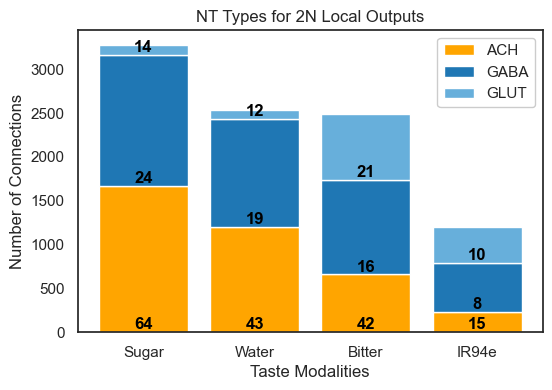

In [68]:
# Start with local neurons/outputs

NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]

# Function to count the number of local 2N output connections with each NT type
def count_NTs_local(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

# Function to count the number of local 2Ns for each NT type - this is to get an idea of how many neurons contribute to each category
def count_neurons_local(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

# Run functions above
variables = count_NTs_local(datasets, categories)
neurons = count_neurons_local(datasets, categories)

# Make plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 2N Local Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

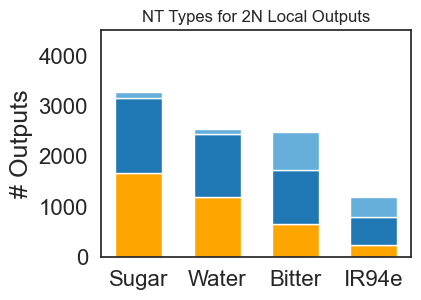

In [69]:
# Make same figures as above but without neuron number labels (+ adjust formatting)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
#ax.legend(NTs, frameon=False)
plt.ylim(0,4500)
ax.set_title('NT Types for 2N Local Outputs')
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

In [70]:
# Show numbers of outputs for each NT type
variables

(array([1664, 1198,  660,  232]),
 array([1500, 1234, 1073,  554]),
 array([114, 103, 751, 412]))

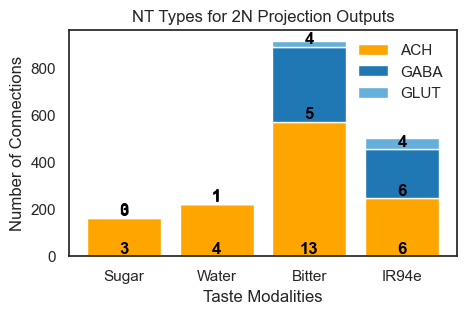

In [71]:
# Now do projection neurons/outputs

NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]

# Function to count the number of projection 2N outputs for each NT type
def count_NTs_proj(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")))
        ACH_connections = np.array(variable1)
        variable2.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")))
        GABA_connections = np.array(variable2)
        variable3.append(len(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")))
        GLUT_connections = np.array(variable3)
    return ACH_connections,GABA_connections,GLUT_connections

# Function to count the number of projection 2Ns for each NT type - this is to get an idea of how many neurons contribute to each category
def count_neurons_proj(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    for dataset in datasets:
        variable1.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[0]")['pre_root_id'].nunique())
        ACH_neurons = np.array(variable1)
        variable2.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[1]")['pre_root_id'].nunique())
        GABA_neurons = np.array(variable2)
        variable3.append(dataset.query("location_of_connection == 'outside_SEZ' and nt_type == @NTs[2]")['pre_root_id'].nunique())
        GLUT_neurons = np.array(variable3)
    return ACH_neurons,GABA_neurons,GLUT_neurons

# Run functions
variables = count_NTs_proj(datasets, categories)
neurons = count_neurons_proj(datasets, categories)

# Make plot
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs, frameon=False)
ax.set_title('NT Types for 2N Projection Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

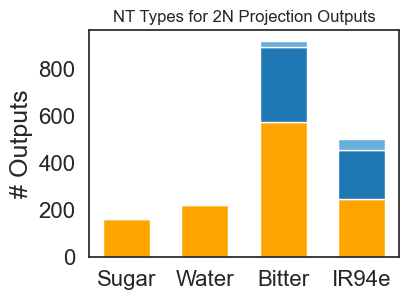

In [72]:
# Make same figure as above but without labels (+ adjust formatting)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
#ax.legend(NTs, frameon=False)
ax.set_title('NT Types for 2N Projection Outputs')
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

In [73]:
# Show numbers of outputs for each NT type
variables

(array([162, 222, 572, 247]),
 array([  4,   1, 318, 208]),
 array([ 0,  3, 26, 47]))

### Quantifying ipsilateral vs. contralateral 2N outputs across modalities

In [74]:
# Define left vs. right sides as ipsilateral vs. contralateral
def bilateral(neuropil):
    if neuropil.endswith('_L'):
        return 'ipsilateral'
    elif neuropil.endswith('_R'):
        return 'contralateral'
    else:
        return 'central'

In [75]:
# Classify ipsi vs. contra side for each output
sugar2N_outputs['hemisphere'] = sugar2N_outputs['neuropil'].apply(bilateral)
water2N_outputs['hemisphere'] = water2N_outputs['neuropil'].apply(bilateral)
bitter2N_outputs['hemisphere'] = bitter2N_outputs['neuropil'].apply(bilateral)
lowsalt2N_outputs['hemisphere'] = lowsalt2N_outputs['neuropil'].apply(bilateral)

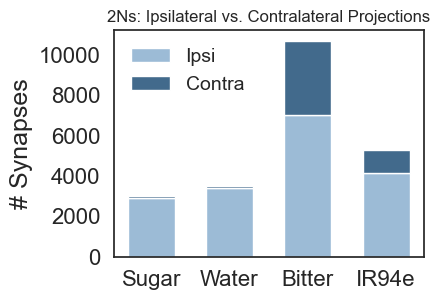

In [76]:
# Plot number of ipsi vs. contra output synapses for 2Ns
second_order_outputs = [sugar2N_outputs, water2N_outputs, bitter2N_outputs, lowsalt2N_outputs]
ipsilateral = []
contralateral = []

for entry in second_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['Sugar', 'Water', 'Bitter', 'IR94e']
brain_hemisphere = ['Ipsi', 'Contra']

bar_width = 0.6
plt.figure(figsize=(4,3))
plt.bar(categories, ipsilateral, color = '#9cbbd6', width = bar_width)
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c', width = bar_width)
plt.title('2Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(brain_hemisphere, frameon=False, fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [77]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

[2903, 3404, 6991, 4160]
[85, 94, 3679, 1140]


### Quantify 2N projections to each brain region

Start by consolidating bilateral brain regions for second order outputs.

In [78]:
# Creates a new column with region names excluding side
original_neuropil_list = connections['neuropil'].unique()
region_mapping = {}
for neuropil in original_neuropil_list:
    if neuropil.endswith('_L') or neuropil.endswith('_R'):
        prefix = neuropil[:-2]
        region_mapping[neuropil] = prefix
    else:
        region_mapping[neuropil] = neuropil

In [79]:
# Apply the function above
sugar2N_outputs['neuropil_remap'] = sugar2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
water2N_outputs['neuropil_remap'] = water2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
bitter2N_outputs['neuropil_remap'] = bitter2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
lowsalt2N_outputs['neuropil_remap'] = lowsalt2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Create bar graphs of non-SEZ brain regions with 2N outputs

In [80]:
# First, determine the top 12 non-SEZ brain regions for 2N outputs for each modality

def get_top12_regions(outputs):
    
    # sum over neuropil remap
    synapses_by_region = outputs.groupby('neuropil_remap')['syn_count'].sum()
    
    # exclude SEZ
    synapses_by_region = synapses_by_region.drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'],errors='ignore')
    
    # take top 12
    top12 = list(synapses_by_region.sort_values().index[-12:])
    
    return top12

sugar2N_top12 = get_top12_regions(sugar2N_outputs)
water2N_top12 = get_top12_regions(water2N_outputs)
bitter2N_top12 = get_top12_regions(bitter2N_outputs)
lowsalt2N_top12 = get_top12_regions(lowsalt2N_outputs)

print(sugar2N_top12)
print(water2N_top12)
print(bitter2N_top12)
print(lowsalt2N_top12)

['AL', 'PVLP', 'IPS', 'VES', 'MB_VL', 'SCL', 'SIP', 'LH', 'SLP', 'SMP']
['VES', 'AL', 'PLP', 'PVLP', 'SLP', 'MB_CA', 'SCL', 'LH']
['ICL', 'MB_CA', 'AL', 'SMP', 'SIP', 'MB_PED', 'PLP', 'PVLP', 'AVLP', 'LH', 'SCL', 'SLP']
['AL', 'SMP', 'WED', 'VES', 'MB_PED', 'PVLP', 'SIP', 'AVLP', 'PLP', 'LH', 'SCL', 'SLP']


In [81]:
# Make a list of regions in the top 6 for any modality, which captures > 95% of outputs for each modality (see below)
all_regions_2Ns = list(
    set(sugar2N_top12[-6:]) | set(water2N_top12[-6:]) | set(bitter2N_top12[-6:]) | set(lowsalt2N_top12[-6:]))

all_regions_2Ns

['MB_VL', 'SLP', 'LH', 'SIP', 'SMP', 'MB_CA', 'PVLP', 'AVLP', 'SCL', 'PLP']

In [82]:
# Define custom order for these brain regions
categories = ['SMP','SIP','SLP',
                'SCL',
                'MB_CA','MB_VL',
                'LH',
                'AVLP','PVLP','PLP']

# Define NT types so we can plot them separately
NTs = ['ACH','GABA','GLUT','DA', 'SER']

In [83]:
# Define function to count output synapses by NT type in each brain region

def count_NTs_brainregions(datasets_array,NTs_array):
    variable1 = []
    variable2 = []
    variable3 =[]
    variable4 =[]
    
    for dataset in datasets:
        
        variable1.append(dataset.query("nt_type == @NTs[0]")['syn_count'].sum()) #Ach
        ACH_connections = np.array(variable1)
        
        variable2.append(dataset.query("nt_type == @NTs[1]")['syn_count'].sum()) #GABA
        GABA_connections = np.array(variable2)
        
        variable3.append(dataset.query("nt_type == @NTs[2]")['syn_count'].sum()) #Glut
        GLUT_connections = np.array(variable3)
        
        variable4.append(
            dataset.query("nt_type == @NTs[3]")['syn_count'].sum() + 
            dataset.query("nt_type == @NTs[4]")['syn_count'].sum()
        )
        other_connections = np.array(variable4) #other NTs
        
    return ACH_connections,GABA_connections,GLUT_connections, other_connections

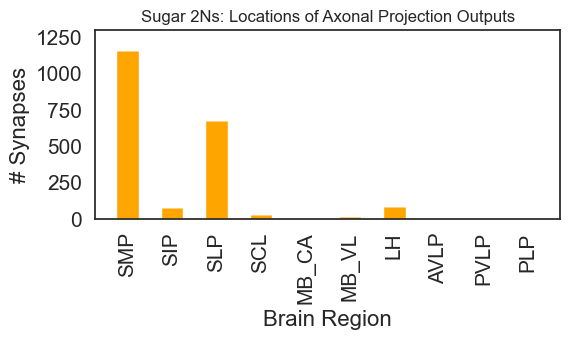

In [84]:
# Make bar graph showing outputs of sugar 2Ns, colored by NT type
datasets = []
for category in categories:
    counts = pd.DataFrame(sugar2N_outputs[sugar2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and aren't visible in the graph anyway
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) # Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) # GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) # Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.ylim(0,1300)
plt.title('Sugar 2Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs, frameon=False)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [85]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/sugar2N_outputs[sugar2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9870192307692308

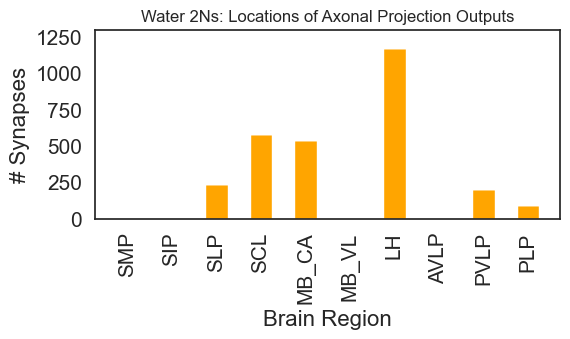

In [86]:
# Make bar graph showing outputs of water 2Ns, colored by NT
datasets = []
for category in categories:
    counts = pd.DataFrame(water2N_outputs[water2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and aren't visible in the graph anyway
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5)  #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.ylim(0,1300)
plt.title('Water 2Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs, frameon=False)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [87]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/water2N_outputs[water2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9655642686668939

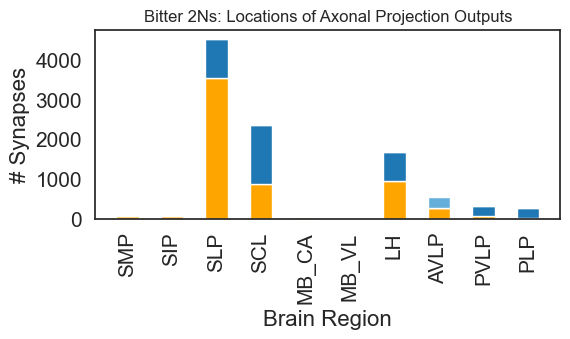

In [88]:
# Make bar graph showing outputs of bitter 2Ns, colored by NT
datasets = []
for category in categories:
    counts = pd.DataFrame(bitter2N_outputs[bitter2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and aren't visible in the graph anyway
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Bitter 2Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs, frameon=False)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [89]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/bitter2N_outputs[bitter2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9735800514545815

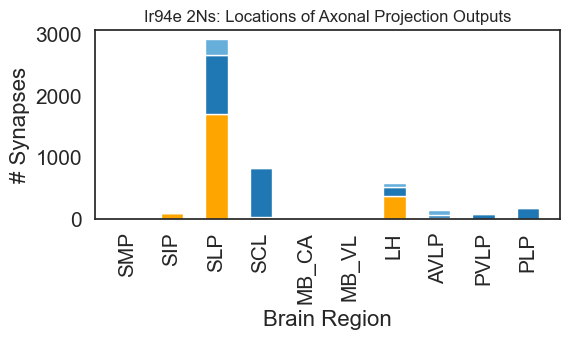

In [90]:
# Make bar graph showing outputs of IR94e 2Ns, colored by NT
datasets = []
for category in categories:
    counts = pd.DataFrame(lowsalt2N_outputs[lowsalt2N_outputs['neuropil_remap'] == category])
    datasets.append(counts)
    
variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and aren't visible in the graph anyway
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Ir94e 2Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs, frameon=False)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [91]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/lowsalt2N_outputs[lowsalt2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9796375483608226

## 3. THIRD ORDER NEURON ANALYSES

## 3a. Identify 3Ns and their connections and organize the data

### Define a function to identify third order neurons (3Ns)
- must be downstream of 2Ns and not a GRN
- minimum of 10 synapses from GRN to 2N
- minimum of 10 synapses from 2N to 3N 

Note that these criteria use a more stringent threshold (10 synapses) than for 2Ns.

In [92]:
# Function to define 2N-3N connectivity and get lists of 3Ns
def third_order(taste_second_order_connectivity, taste, taste_second_orders):
        connectivity = pd.merge(taste_second_order_connectivity.query("syn_count >= 10")['post_root_id'], connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']], \
                left_on = 'post_root_id', right_on = 'pre_root_id', how = 'inner').query("syn_count >= 10")
        connectivity = connectivity.drop(columns = 'post_root_id_x')
        connectivity.rename(columns={'post_root_id_y': 'post_root_id'}, inplace=True)
        GRNs = pd.concat([sugar_GRNs['root_id'],  water_GRNs['root_id'], bitter_GRNs['root_id'],lowsalt_GRNs['root_id']])
        connectivity = connectivity[~connectivity['pre_root_id'].isin(GRNs)] # drop entries where GRN is presynaptic
        connectivity = connectivity[~connectivity['post_root_id'].isin(GRNs)] # drop if GRN is postsynaptic
        connectivity = connectivity[~connectivity['post_root_id'].isin(taste_second_orders['root_id'])] # drop if 2N of same modality is postsynaptic
        connectivity = connectivity.drop_duplicates()
        third_orders = connectivity.groupby("post_root_id").agg({'pre_root_id' : 'nunique', 'syn_count' : 'sum'}).reset_index()
        third_orders.columns = ['root_id','upstream_' + taste + '_2Ns', taste + '_syn_count']
        third_orders['const'] = 1  # this will be used for OLS regression
        return connectivity, third_orders

In [93]:
# Get 2N-3N connectivity and 3N lists for each modality
sugar_third_order_connectivity, sugar_3Ns = third_order(sugar_second_order_connectivity, 'sugar', sugar_2Ns)
water_third_order_connectivity, water_3Ns = third_order(water_second_order_connectivity, 'water', water_2Ns)
bitter_third_order_connectivity, bitter_3Ns = third_order(bitter_second_order_connectivity, 'bitter', bitter_2Ns)
lowsalt_third_order_connectivity, lowsalt_3Ns = third_order(lowsalt_second_order_connectivity, 'lowsalt', lowsalt_2Ns)

In [94]:
# inspect connectivity dataframe
sugar_third_order_connectivity

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940611015122,720575940607272649,GNG,10,ACH
2,720575940611015122,720575940607386290,GNG,15,ACH
7,720575940611015122,720575940620879476,GNG,11,ACH
9,720575940611015122,720575940623578375,GNG,12,ACH
10,720575940611015122,720575940626495746,GNG,29,ACH
...,...,...,...,...,...
12409,720575940612648106,720575940627404858,PRW,16,ACH
12410,720575940612648106,720575940627404858,GNG,34,ACH
12413,720575940612648106,720575940628391686,GNG,33,ACH
12415,720575940612648106,720575940628675433,GNG,17,ACH


In [95]:
# List how many 3Ns we have
print(np.unique(sugar_3Ns.root_id.values).shape)
print(np.unique(water_3Ns.root_id.values).shape)
print(np.unique(bitter_3Ns.root_id.values).shape)
print(np.unique(lowsalt_3Ns.root_id.values).shape)

# inspect list of sugar 3Ns
sugar_3Ns

(515,)
(324,)
(396,)
(222,)


,root_id,upstream_sugar_2Ns,sugar_syn_count,const
0,720575940604030566,2,24,1
1,720575940605282406,1,17,1
2,720575940605658033,1,23,1
3,720575940606421122,1,13,1
4,720575940606567125,3,75,1
...,...,...,...,...
510,720575940659340673,2,69,1
511,720575940660223873,3,55,1
512,720575940660229505,3,149,1
513,720575940660233601,1,10,1


### Getting more information about 3Ns from Flywire's data repository
Again we are using files from snapshot 630.

In [96]:
# Select and merge rows from neurons_data for each set of 3Ns
sugar_3Ns = pd.merge(sugar_3Ns, neurons_data, on = 'root_id', how = 'inner')
water_3Ns = pd.merge(water_3Ns, neurons_data, on = 'root_id', how = 'inner')
bitter_3Ns = pd.merge(bitter_3Ns, neurons_data, on = 'root_id', how = 'inner')
lowsalt_3Ns = pd.merge(lowsalt_3Ns, neurons_data, on = 'root_id', how = 'inner')

In [97]:
# inspect dataframe
sugar_3Ns

,root_id,upstream_sugar_2Ns,sugar_syn_count,const,nt_type,side,input_synapses,output_synapses
0,720575940604030566,2,24,1,ACH,right,76.0,271.0
1,720575940605282406,1,17,1,ACH,right,286.0,138.0
2,720575940605658033,1,23,1,NaN,right,2109.0,0.0
3,720575940606421122,1,13,1,GABA,right,1077.0,1276.0
4,720575940606567125,3,75,1,ACH,left,123.0,323.0
...,...,...,...,...,...,...,...,...
510,720575940659340673,2,69,1,GABA,left,1158.0,2091.0
511,720575940660223873,3,55,1,ACH,left,1407.0,2354.0
512,720575940660229505,3,149,1,NaN,right,2666.0,0.0
513,720575940660233601,1,10,1,GABA,left,1056.0,2040.0


## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

We are comparing the observed proportion of excitatory or inhibitory convergence to the proportion expected by chance. 

### Transform the 2N-3N connectivity data so that each row is a unique 2N-3N pair

This is necessary because the 2N-3N connectivity data may include the same 2N-3N pair multiple times if they connect in multiple regions.

We also want to label NT type for each 2N-3N synapse using the "neurons" dataset; otherwise the synapse labels for the same 2N-3N pair sometimes conflict. Note that this is different from other analyses that just use synapse labels.

In [98]:
# Define a function that transforms 2N-3N connectivity as described above
def get_3N_inputs(third_order_connectivity):

    # Drop neuropil and NT type
    toc = third_order_connectivity.drop(['neuropil','nt_type'], axis=1)

    # Join nt_type from neurons_data
    toc = toc.join(neurons_data.set_index('root_id')['nt_type'], on='pre_root_id')

    # Drop all neurons for which NT type is null in original neurons dataset
    # sugar_toc = sugar_toc.dropna(subset='nt_type')
    toc = toc[~toc['nt_type'].isnull()]

    # Drop neurons that are not Ach, GABA, Glut
    toc = toc[toc['nt_type'].isin(['GABA','ACH','GLUT'])]

    # replace NT labels with "E" or "I"
    toc['nt_type'] = toc['nt_type'].replace(
        {'GABA': 'I', 'ACH': 'E', 'GLUT': 'I'})

    # Aggregate duplicate connections
    toc = toc.groupby(
        ['pre_root_id', 'post_root_id','nt_type']
        )['syn_count'].sum().reset_index()
    
    return toc

# run the function for each modality
sugar_toc = get_3N_inputs(sugar_third_order_connectivity)
water_toc = get_3N_inputs(water_third_order_connectivity)
bitter_toc = get_3N_inputs(bitter_third_order_connectivity)
lowsalt_toc = get_3N_inputs(lowsalt_third_order_connectivity)

In [99]:
# Show the new connectivity dataframe - has fewer connections than original because of drops
sugar_toc

,pre_root_id,post_root_id,nt_type,syn_count
0,720575940606866377,720575940606801282,I,13
1,720575940606866377,720575940607737099,I,14
2,720575940606866377,720575940608305161,I,25
3,720575940606866377,720575940609919897,I,19
4,720575940606866377,720575940612422579,I,16
...,...,...,...,...
890,720575940655014049,720575940638663221,E,13
891,720575940655014049,720575940639785379,E,32
892,720575940655014049,720575940644750116,E,10
893,720575940655014049,720575940652580086,E,39


### First, analyze 3Ns with exactly two 2N inputs

Consider 3Ns with exactly two 2N inputs. We calculate the rate of inputs being both excitatory (EE), both inhibitory (II), or different (EI or IE) by probability rules, based on knowing the frequency of excitatory and inhibitory inputs for that dataset. 

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of both inputs being excitatory (EE) is 0.3\*0.3

Chance of both inputs being inhibitory (II) is 0.7\*0.7

Chance of having one excitatory and one inhibitory input (EI or IE) is (0.3\*0.7) + (0.7\*0.3) = 2\*(0.3\*0.7). 

Then, we compare this chance rate for congruent vs. incongruent inputs to the actual rates.

In [100]:
# Quantify the expected and actual number of 3Ns in each category above
# (Note that in the code below, EI refers to either EI or IE)

def get_probs_connectivity_2input (toc):
    
    # calculate number of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack().fillna(0).astype(int)
    number_EE = n_neurons_for_each_EI.loc[2].loc[0]
    number_II = n_neurons_for_each_EI.loc[0].loc[2]
    number_EI = n_neurons_for_each_EI.loc[1].loc[1]

    # calculate the number of excitatory, inhibitory, and total 2N input connections for 3Ns in this dataset
    number_excit = number_EE*2 + number_EI
    number_inhib = number_II*2 + number_EI
    number_tot  = number_excit + number_inhib

    # calculate the probabilities expected by random chance
    prob_EE_chance = (number_excit/number_tot)**2
    prob_II_chance = (number_inhib/number_tot)**2
    prob_EI_chance = 2*(number_excit/number_tot)*(number_inhib/number_tot)

    # calculate the actual proportions of EE, EI, or II in the dataset
    # note that dividing number_tot by 2 gives you the number of 3Ns since each 3N gets two input connections
    prob_EE_actual = number_EE/ (number_tot/2)
    prob_EI_actual = number_EI/ (number_tot/2)
    prob_II_actual = number_II/ (number_tot/2)
    
    # make sure the proportions sum to 1
    tot_chance = prob_EE_chance + prob_EI_chance + prob_II_chance
    tot_actual = prob_EE_actual + prob_EI_actual + prob_II_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance )
    
    # print comparison
    print ('''probability of two excitatory synapses by random chance is {} while the found frequency is {}
    probability of two inhibitory synapses by random chance is {} while the found frequency is {}
    probability of one inhibitory synapses and one excitatory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EE_chance,3), round(prob_EE_actual,3) , round(prob_II_chance,3),round(prob_II_actual,3),round(prob_EI_chance,3),round(prob_EI_actual,3)))
    
    # print values
    print('probability EE:', prob_EE_chance)
    print('probability II:', prob_II_chance)
    print('probability EI:', prob_EI_chance)
    print('actual number EE:', number_EE)
    print('actual number II:', number_II)
    print('actual number EI:', number_EI)

In [101]:
# run function for sugar
get_probs_connectivity_2input(sugar_toc)

probability of two excitatory synapses by random chance is 0.228 while the found frequency is 0.384
    probability of two inhibitory synapses by random chance is 0.273 while the found frequency is 0.429
    probability of one inhibitory synapses and one excitatory synapse by random chance is 0.499 while the found frequency is 0.188
                                              
probability EE: 0.22817681760204084
probability II: 0.272819674744898
probability EI: 0.4990035076530613
actual number EE: 43
actual number II: 48
actual number EI: 21


In [102]:
# run function for water
get_probs_connectivity_2input(water_toc)

probability of two excitatory synapses by random chance is 0.072 while the found frequency is 0.254
    probability of two inhibitory synapses by random chance is 0.536 while the found frequency is 0.718
    probability of one inhibitory synapses and one excitatory synapse by random chance is 0.392 while the found frequency is 0.028
                                              
probability EE: 0.07161277524300733
probability II: 0.5364015076373736
probability EI: 0.3919857171196191
actual number EE: 18
actual number II: 51
actual number EI: 2


In [103]:
# run function for bitter
get_probs_connectivity_2input(bitter_toc)

probability of two excitatory synapses by random chance is 0.055 while the found frequency is 0.214
    probability of two inhibitory synapses by random chance is 0.586 while the found frequency is 0.745
    probability of one inhibitory synapses and one excitatory synapse by random chance is 0.359 while the found frequency is 0.041
                                              
probability EE: 0.05508121615993337
probability II: 0.5856934610578924
probability EI: 0.3592253227821741
actual number EE: 21
actual number II: 73
actual number EI: 4


In [104]:
# run function for lowsalt
get_probs_connectivity_2input(lowsalt_toc)

probability of two excitatory synapses by random chance is 0.002 while the found frequency is 0.042
    probability of two inhibitory synapses by random chance is 0.918 while the found frequency is 0.958
    probability of one inhibitory synapses and one excitatory synapse by random chance is 0.08 while the found frequency is 0.0
                                              
probability EE: 0.001736111111111111
probability II: 0.9184027777777779
probability EI: 0.0798611111111111
actual number EE: 3
actual number II: 69
actual number EI: 0


### Analyze 3Ns with exactly three 2N inputs

Consider 3Ns with exactly three 2N inputs. We use probability rules to calculate the rate of inputs being all excitatory (EEE), all inhibitory (III), 2 excitatory 1 inhibitory (EEI, EIE, IEE), or 2 inhibitory 1 excitatory (IIE, IEI, EII), based on knowing the frequency of excitatory and inhibitory inputs for that dataset.

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of all inputs being excitatory (EEE) is 0.3\*0.3\*0.3. 

Chance of all inputs being inhibitory (III) is 0.7\*0.7\*0.7. 

Chance of two excitatory inputs and one inhibitory input (EEI, EIE, IEE) is 3\*(0.3\*0.3\*0.7) because there are 3 ways to get it.

Chance of two inhibitory inputs and one excitatory input (IIE, IEI, EII) is 3\*(0.7\*0.7\*0.3) because there are 3 ways to get it.

Again, compare the chance rate for congruent vs. incongruent inputs to the actual rates. 

In [105]:
# Quantify the expected and actual number of 3Ns in each category above
# (Note that here by EEI we also mean EIE or IEE, and by EII we also mean IEI and IIE)

def get_probs_connectivity_3input (toc):

    # calculate number of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack()
    n_neurons_for_each_EI = n_neurons_for_each_EI.reindex(range(4)).reindex(range(4), axis=1)
    n_neurons_for_each_EI = n_neurons_for_each_EI.fillna(0).astype(int)
    number_EEE = n_neurons_for_each_EI.loc[3].loc[0]
    number_III = n_neurons_for_each_EI.loc[0].loc[3]
    number_EEI = n_neurons_for_each_EI.loc[2].loc[1]
    number_EII = n_neurons_for_each_EI.loc[1].loc[2]

    # calculate the number of excitatory, inhibitory, and total input connections for 3Ns in this dataset
    number_excit = number_EEE*3 + number_EEI*2 + number_EII
    number_inhib = number_III*3 + number_EII*2 + number_EEI
    number_tot  = number_excit + number_inhib  

    # calculate the probabilities expected by random chance
    prob_EEE_chance = (number_excit/number_tot)**3
    prob_EEI_chance = 3*(number_inhib/number_tot)*((number_excit/number_tot)**2)
    prob_EII_chance = 3*(number_excit/number_tot)*((number_inhib/number_tot)**2)
    prob_III_chance = (number_inhib/number_tot)**3
    
    # calculate the actual proportions of each category in the dataset
    # note that dividing number_tot by 3 gives you the number of 3Ns since each 3N gets 3 input connections
    prob_EEE_actual = number_EEE/ (number_tot/3)
    prob_EEI_actual = number_EEI/ (number_tot/3)
    prob_EII_actual = number_EII/ (number_tot/3)
    prob_III_actual = number_III/ (number_tot/3)
    
    # make sure the proportions/probabilities sum to 1
    tot_chance = prob_EEE_chance + prob_EEI_chance + prob_EII_chance + prob_III_chance
    tot_actual = prob_EEE_actual + prob_EEI_actual + prob_EII_actual + prob_III_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance)
    
    # print comparison
    print ('''probability of three excitatory synapses by random chance is {} while the found frequency is {}
probability of three inhibitory synapses by random chance is {} while the found frequency is {}
probability of two excitatory synapse and one inhibitory synapse by random chance is {} while the found frequency is {}
probability of one excitatory synapse and two inhibitory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EEE_chance,4), round(prob_EEE_actual,4) , round(prob_III_chance,4),round(prob_III_actual,4),round(prob_EEI_chance,4),round(prob_EEI_actual,4),round(prob_EII_chance,4),round(prob_EII_actual,4)))
    
    # print values
    print('probability EEE:', prob_EEE_chance)
    print('probability III:', prob_III_chance)
    print('probability EEI:', prob_EEI_chance)
    print('probability EII:', prob_EII_chance)
    print('actual number EEE:', number_EEE)
    print('actual number III:', number_III)
    print('actual number EEI:', number_EEI)
    print('actual number EII:', number_EII)

In [106]:
get_probs_connectivity_3input(sugar_toc) #sugar neurons

probability of three excitatory synapses by random chance is 0.033 while the found frequency is 0.283
probability of three inhibitory synapses by random chance is 0.3134 while the found frequency is 0.6415
probability of two excitatory synapse and one inhibitory synapse by random chance is 0.2096 while the found frequency is 0.0377
probability of one excitatory synapse and two inhibitory synapse by random chance is 0.444 while the found frequency is 0.0377
                                              
probability EEE: 0.033000396300301583
probability III: 0.3133862181532405
probability EEI: 0.20964957649603363
probability EII: 0.4439638090504241
actual number EEE: 15
actual number III: 34
actual number EEI: 2
actual number EII: 2


In [107]:
get_probs_connectivity_3input(water_toc) #water neurons

probability of three excitatory synapses by random chance is 0.0156 while the found frequency is 0.0833
probability of three inhibitory synapses by random chance is 0.4219 while the found frequency is 0.5
probability of two excitatory synapse and one inhibitory synapse by random chance is 0.1406 while the found frequency is 0.0833
probability of one excitatory synapse and two inhibitory synapse by random chance is 0.4219 while the found frequency is 0.3333
                                              
probability EEE: 0.015625
probability III: 0.421875
probability EEI: 0.140625
probability EII: 0.421875
actual number EEE: 1
actual number III: 6
actual number EEI: 1
actual number EII: 4


In [108]:
get_probs_connectivity_3input(bitter_toc) #bitter neurons

probability of three excitatory synapses by random chance is 0.009 while the found frequency is 0.0
probability of three inhibitory synapses by random chance is 0.4962 while the found frequency is 0.625
probability of two excitatory synapse and one inhibitory synapse by random chance is 0.1031 while the found frequency is 0.25
probability of one excitatory synapse and two inhibitory synapse by random chance is 0.3917 while the found frequency is 0.125
                                              
probability EEE: 0.009042245370370372
probability III: 0.4961660879629629
probability EEI: 0.10308159722222224
probability EII: 0.3917100694444444
actual number EEE: 0
actual number III: 5
actual number EEI: 2
actual number EII: 1


In [109]:
get_probs_connectivity_3input(lowsalt_toc) #lowsalt neurons

probability of three excitatory synapses by random chance is 0.0 while the found frequency is 0.0
probability of three inhibitory synapses by random chance is 1.0 while the found frequency is 1.0
probability of two excitatory synapse and one inhibitory synapse by random chance is 0.0 while the found frequency is 0.0
probability of one excitatory synapse and two inhibitory synapse by random chance is 0.0 while the found frequency is 0.0
                                              
probability EEE: 0.0
probability III: 1.0
probability EEI: 0.0
probability EII: 0.0
actual number EEE: 0
actual number III: 2
actual number EEI: 0
actual number EII: 0


Only a small proportion of 3Ns receive more than three 2N inputs from the same modality, and in many of those cases the expected number of 3Ns receiving certain types of input (e.g., all excitatory) are zero, so we did not include analyses of these neurons.

## 3c. Quantify how many 3Ns were activated in the simulations

Note that this does not follow the order of analyses in the paper; this analysis is shown in Figure 6.

### Calculate number of excitatory and inhibitory 2Ns and 2N synapses onto each 3N

In [110]:
# First, calculate number of excitatory and inhibitory 2Ns and 2N synapses onto each 3N
# Add these columns to the 3N neuron dataframes

def get_number_exc_inh(_3Ns, toc):
    
    new_3Ns = _3Ns.copy()
    
    # Calculate number of excitatory and inhibitory input cells for each 3N
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.rename(columns={'E': 'excitatory_number_upstream_neurons', 'I': 'inhibitory_number_upstream_neurons'})
    
    # Calculate the total number of excitatory and inhibitory input synapses onto each 3N
    n_synapses = toc.groupby(['post_root_id','nt_type'])['syn_count'].sum().unstack('nt_type').fillna(0).astype(int)
    n_synapses = n_synapses.rename(columns={'E': 'excitatory_number_input_synapse', 'I': 'inhibitory_number_input_synapse'})
    
    # join on the 3N dataframe
    new_3Ns = new_3Ns.join(n_inputs, on='root_id')
    new_3Ns = new_3Ns.join(n_synapses, on='root_id')
    
    # Fill nulls with zeros (presumably 3Ns that get inputs that are not Ach, GABA, Glut)
    new_3Ns['excitatory_number_upstream_neurons'] = new_3Ns['excitatory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_upstream_neurons'] = new_3Ns['inhibitory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['excitatory_number_input_synapse'] = new_3Ns['excitatory_number_input_synapse'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_input_synapse'] = new_3Ns['inhibitory_number_input_synapse'].fillna(0).astype(int)
    
    new_3Ns['excitatory - inhibitory_number_input_synapse'] = (
        new_3Ns['excitatory_number_input_synapse'] - new_3Ns['inhibitory_number_input_synapse'])
    
    return new_3Ns

In [111]:
sugar_3Ns = get_number_exc_inh(sugar_3Ns,sugar_toc)
water_3Ns = get_number_exc_inh(water_3Ns, water_toc)
bitter_3Ns = get_number_exc_inh(bitter_3Ns, bitter_toc)
lowsalt_3Ns = get_number_exc_inh(lowsalt_3Ns, lowsalt_toc)

In [112]:
# inspect new dataframe
sugar_3Ns

,root_id,upstream_sugar_2Ns,sugar_syn_count,const,nt_type,side,input_synapses,output_synapses,excitatory_number_upstream_neurons,inhibitory_number_upstream_neurons,excitatory_number_input_synapse,inhibitory_number_input_synapse,excitatory - inhibitory_number_input_synapse
0,720575940604030566,2,24,1,ACH,right,76.0,271.0,0,2,0,24,-24
1,720575940605282406,1,17,1,ACH,right,286.0,138.0,0,1,0,17,-17
2,720575940605658033,1,23,1,NaN,right,2109.0,0.0,1,0,23,0,23
3,720575940606421122,1,13,1,GABA,right,1077.0,1276.0,1,0,13,0,13
4,720575940606567125,3,75,1,ACH,left,123.0,323.0,0,3,0,75,-75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,720575940659340673,2,69,1,GABA,left,1158.0,2091.0,2,0,69,0,69
511,720575940660223873,3,55,1,ACH,left,1407.0,2354.0,3,0,55,0,55
512,720575940660229505,3,149,1,NaN,right,2666.0,0.0,3,0,149,0,149
513,720575940660233601,1,10,1,GABA,left,1056.0,2040.0,0,1,0,10,-10


### Add data from the simulations to the 3N dataframes 

In [113]:
rates= [25,50,75,100,125,150,175,200] # these are the different GRN stimulation rates for the simulations

for i in rates:
    ids_activated = pd.read_csv('simulation/sugarGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    sugar_3Ns['activation_'+str(i)+'Hz'] = sugar_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    sugar_3Ns['label'] = 'sugar'

for i in rates:
    ids_activated = pd.read_csv('simulation/waterGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    water_3Ns['activation_'+str(i)+'Hz'] = water_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    water_3Ns['label'] = 'water'
    
for i in rates:
    ids_activated = pd.read_csv( 'simulation/bitterGRN_' + str(i) + 'Hz_rates.csv')['flyid'].values
    bitter_3Ns['activation_'+str(i)+'Hz'] = bitter_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    bitter_3Ns['label'] = 'bitter'
    
for i in rates:
    ids_activated = pd.read_csv('simulation/IR94eGRN_'+str(i)+'Hz_rates.csv')['flyid'].values
    lowsalt_3Ns['activation_'+str(i)+'Hz'] = lowsalt_3Ns['root_id'].apply(lambda x: 'activated' if x in ids_activated else 'non activated')
    lowsalt_3Ns['label'] = 'low salt'

### Make a dataframe for all modalities

In [114]:
all_3N = pd.concat([sugar_3Ns,water_3Ns,bitter_3Ns,lowsalt_3Ns])
cols_merge_syn_2N_input = ['sugar_syn_count', "water_syn_count", "bitter_syn_count","lowsalt_syn_count"]
all_3N =all_3N.assign(_2N_syn_count=all_3N[cols_merge_syn_2N_input].sum(1)).drop(cols_merge_syn_2N_input, 1)
cols_2_merge_upstream_2N = ['upstream_sugar_2Ns', "upstream_water_2Ns", "upstream_bitter_2Ns","upstream_lowsalt_2Ns"]
all_3N  =all_3N.assign(upstream_2N=all_3N[cols_2_merge_upstream_2N].sum(1)).drop(cols_2_merge_upstream_2N, 1)

In [115]:
# inspect the dataframe
all_3N

,root_id,const,nt_type,side,input_synapses,output_synapses,excitatory_number_upstream_neurons,inhibitory_number_upstream_neurons,excitatory_number_input_synapse,inhibitory_number_input_synapse,...,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,_2N_syn_count,upstream_2N
0,720575940604030566,1,ACH,right,76.0,271.0,0,2,0,24,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,24.0,2.0
1,720575940605282406,1,ACH,right,286.0,138.0,0,1,0,17,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,17.0,1.0
2,720575940605658033,1,NaN,right,2109.0,0.0,1,0,23,0,...,sugar,activated,activated,activated,activated,activated,activated,activated,23.0,1.0
3,720575940606421122,1,GABA,right,1077.0,1276.0,1,0,13,0,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,13.0,1.0
4,720575940606567125,1,ACH,left,123.0,323.0,0,3,0,75,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,75.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,720575940647033396,1,GABA,right,1836.0,690.0,1,0,20,0,...,low salt,non activated,non activated,non activated,non activated,non activated,non activated,non activated,20.0,1.0
218,720575940652490742,1,ACH,left,345.0,625.0,1,0,12,0,...,low salt,non activated,non activated,non activated,non activated,non activated,non activated,non activated,12.0,1.0
219,720575940652580086,1,GABA,left,1901.0,1059.0,0,2,0,72,...,low salt,non activated,non activated,non activated,non activated,non activated,non activated,non activated,72.0,2.0
220,720575940654925985,1,ACH,left,1570.0,1710.0,2,0,25,0,...,low salt,non activated,non activated,non activated,non activated,activated,activated,activated,25.0,2.0


In [116]:
# List how many 3Ns we have - make sure we still have the right number
print(np.unique(sugar_3Ns.root_id.values).shape)
print(np.unique(water_3Ns.root_id.values).shape)
print(np.unique(bitter_3Ns.root_id.values).shape)
print(np.unique(lowsalt_3Ns.root_id.values).shape)

(515,)
(324,)
(396,)
(222,)


### Make boxplots comparing number of 2N inputs for activated vs. non-activated 3Ns
There are 6 plots per modality, quantifying the following metrics for activated vs. nonactivated 3Ns at each stimulation intensity:
* number of total 2N synapses
* number of excitatory 2N neurons
* number of inhibitory 2N neurons
* number of excitatory 2N synapses
* number of inhibitory 2N synapses
* net 2N excitation (# excitatory - # inhibitory synapses)

Only plots of total synapses, excitatory synapses, and net excitation are shown in the paper.

### Sugar plots

In [117]:
sugar_activation_25Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_25Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_25Hz_3N['label'] = 'activation 25Hz'
sugar_activation_50Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_50Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_50Hz_3N['label'] = 'activation 50Hz'
sugar_activation_75Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_75Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_75Hz_3N['label'] = 'activation 75Hz'
sugar_activation_100Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_100Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_100Hz_3N['label'] = 'activation 100Hz'
sugar_activation_125Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_125Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_125Hz_3N['label'] = 'activation 125Hz'
sugar_activation_150Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_150Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_150Hz_3N['label'] = 'activation 150Hz'
sugar_activation_175Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_175Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_175Hz_3N['label'] = 'activation 175Hz'
sugar_activation_200Hz_3N = pd.concat([sugar_3Ns.iloc[:,0:12], sugar_3Ns['activation_200Hz'],sugar_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
sugar_activation_200Hz_3N['label'] = 'activation 200Hz'

sugar_activation_vertically_stacked_3N = pd.concat([sugar_activation_25Hz_3N,sugar_activation_50Hz_3N,sugar_activation_75Hz_3N,sugar_activation_100Hz_3N,sugar_activation_125Hz_3N,sugar_activation_150Hz_3N,sugar_activation_175Hz_3N,sugar_activation_200Hz_3N], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
sugar_activation_vertically_stacked_3N['activation'] = sugar_activation_vertically_stacked_3N['activation_25Hz'].fillna('') + sugar_activation_vertically_stacked_3N['activation_50Hz'].fillna('')+ sugar_activation_vertically_stacked_3N['activation_75Hz'].fillna('')+ sugar_activation_vertically_stacked_3N['activation_100Hz'].fillna('')+sugar_activation_vertically_stacked_3N['activation_125Hz'].fillna('')+sugar_activation_vertically_stacked_3N['activation_150Hz'].fillna('')+sugar_activation_vertically_stacked_3N['activation_175Hz'].fillna('')+sugar_activation_vertically_stacked_3N['activation_200Hz'].fillna('')

In [118]:
# inspect dataframe
sugar_activation_vertically_stacked_3N

,root_id,upstream_sugar_2Ns,sugar_syn_count,const,nt_type,side,input_synapses,output_synapses,excitatory_number_upstream_neurons,inhibitory_number_upstream_neurons,...,excitatory - inhibitory_number_input_synapse,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,activation
0,720575940604030566,2,24,1,ACH,right,76.0,271.0,0,2,...,-24,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
1,720575940605282406,1,17,1,ACH,right,286.0,138.0,0,1,...,-17,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
2,720575940605658033,1,23,1,NaN,right,2109.0,0.0,1,0,...,23,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,activated
3,720575940606421122,1,13,1,GABA,right,1077.0,1276.0,1,0,...,13,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
4,720575940606567125,3,75,1,ACH,left,123.0,323.0,0,3,...,-75,activation 25Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,720575940659340673,2,69,1,GABA,left,1158.0,2091.0,2,0,...,69,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,non activated,non activated
511,720575940660223873,3,55,1,ACH,left,1407.0,2354.0,3,0,...,55,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,activated,activated
512,720575940660229505,3,149,1,NaN,right,2666.0,0.0,3,0,...,149,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,activated,activated
513,720575940660233601,1,10,1,GABA,left,1056.0,2040.0,0,1,...,-10,activation 200Hz,NaN,NaN,NaN,NaN,NaN,NaN,non activated,non activated


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

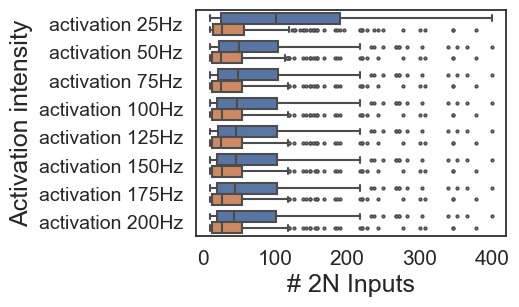

In [119]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="sugar_syn_count", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

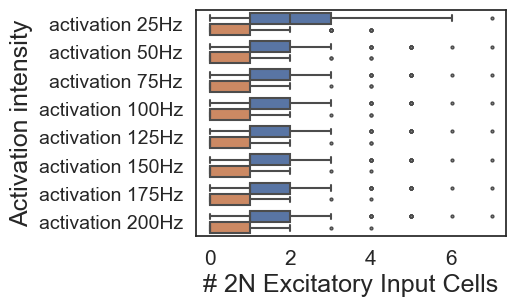

In [120]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="excitatory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

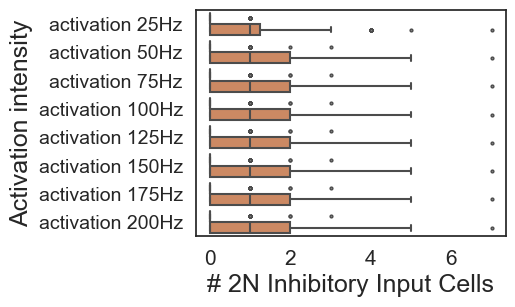

In [121]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="inhibitory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

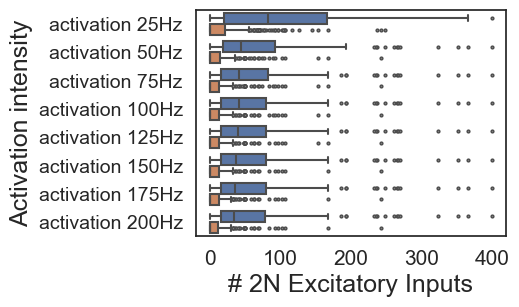

In [122]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="excitatory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

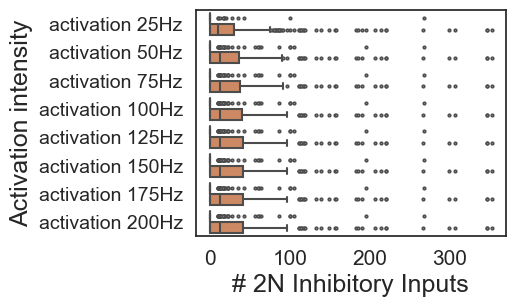

In [123]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

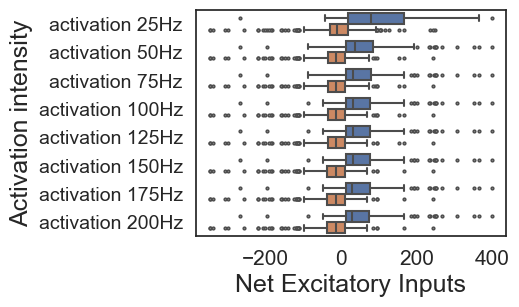

In [124]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=sugar_activation_vertically_stacked_3N, x="excitatory - inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

### Water plots

In [125]:
water_activation_25Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_25Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_25Hz_3N['label'] = 'activation 25Hz'
water_activation_50Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_50Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_50Hz_3N['label'] = 'activation 50Hz'
water_activation_75Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_75Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_75Hz_3N['label'] = 'activation 75Hz'
water_activation_100Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_100Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_100Hz_3N['label'] = 'activation 100Hz'
water_activation_125Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_125Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_125Hz_3N['label'] = 'activation 125Hz'
water_activation_150Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_150Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_150Hz_3N['label'] = 'activation 150Hz'
water_activation_175Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_175Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_175Hz_3N['label'] = 'activation 175Hz'
water_activation_200Hz_3N = pd.concat([water_3Ns.iloc[:,0:12], water_3Ns['activation_200Hz'], water_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
water_activation_200Hz_3N['label'] = 'activation 200Hz'

water_activation_vertically_stacked_3N = pd.concat([water_activation_25Hz_3N,water_activation_50Hz_3N,water_activation_75Hz_3N,water_activation_100Hz_3N,water_activation_125Hz_3N,water_activation_150Hz_3N,water_activation_175Hz_3N,water_activation_200Hz_3N], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
water_activation_vertically_stacked_3N['activation'] = water_activation_vertically_stacked_3N['activation_25Hz'].fillna('') + water_activation_vertically_stacked_3N['activation_50Hz'].fillna('')+ water_activation_vertically_stacked_3N['activation_75Hz'].fillna('')+ water_activation_vertically_stacked_3N['activation_100Hz'].fillna('')+water_activation_vertically_stacked_3N['activation_125Hz'].fillna('')+water_activation_vertically_stacked_3N['activation_150Hz'].fillna('')+water_activation_vertically_stacked_3N['activation_175Hz'].fillna('')+water_activation_vertically_stacked_3N['activation_200Hz'].fillna('')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

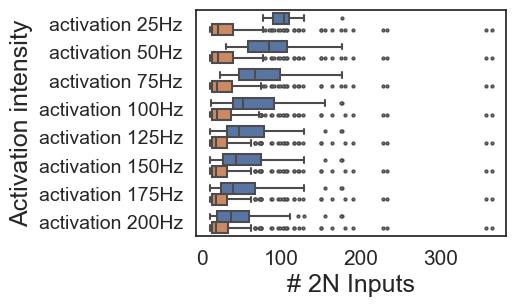

In [126]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="water_syn_count", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

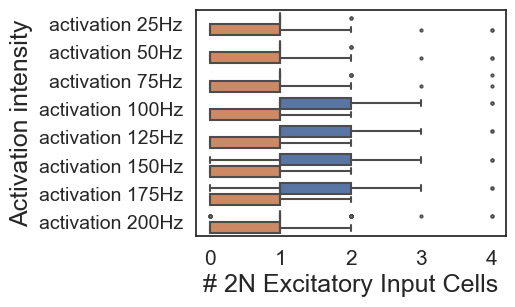

In [127]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="excitatory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

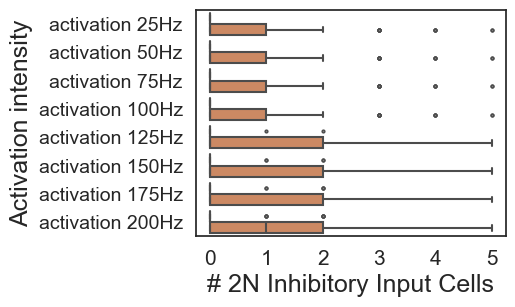

In [128]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="inhibitory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

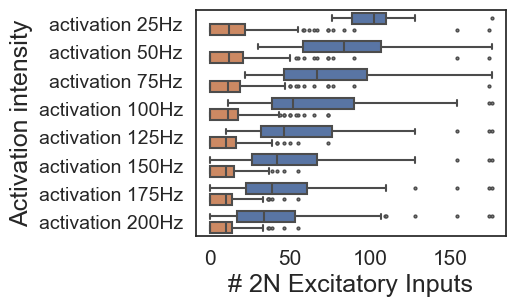

In [129]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="excitatory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

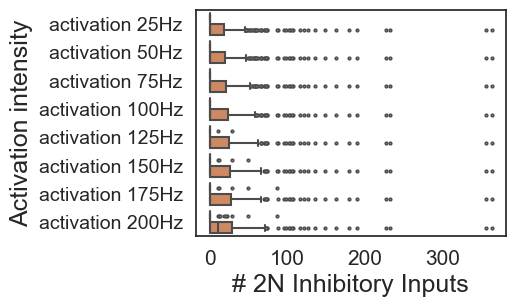

In [130]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

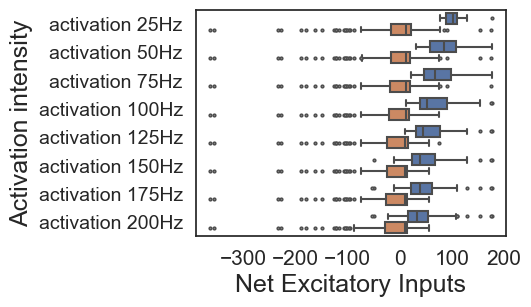

In [131]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=water_activation_vertically_stacked_3N, x="excitatory - inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

### Bitter plots

In [132]:
bitter_activation_25Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_25Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_25Hz_3N['label'] = 'activation 25Hz'
bitter_activation_50Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_50Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_50Hz_3N['label'] = 'activation 50Hz'
bitter_activation_75Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_75Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_75Hz_3N['label'] = 'activation 75Hz'
bitter_activation_100Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_100Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_100Hz_3N['label'] = 'activation 100Hz'
bitter_activation_125Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_125Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_125Hz_3N['label'] = 'activation 125Hz'
bitter_activation_150Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_150Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_150Hz_3N['label'] = 'activation 150Hz'
bitter_activation_175Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_175Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_175Hz_3N['label'] = 'activation 175Hz'
bitter_activation_200Hz_3N = pd.concat([bitter_3Ns.iloc[:,0:12], bitter_3Ns['activation_200Hz'], bitter_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
bitter_activation_200Hz_3N['label'] = 'activation 200Hz'

bitter_activation_vertically_stacked_3N = pd.concat([bitter_activation_25Hz_3N,bitter_activation_50Hz_3N,bitter_activation_75Hz_3N,bitter_activation_100Hz_3N,bitter_activation_125Hz_3N,bitter_activation_150Hz_3N,bitter_activation_175Hz_3N,bitter_activation_200Hz_3N], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
bitter_activation_vertically_stacked_3N['activation'] = bitter_activation_vertically_stacked_3N['activation_25Hz'].fillna('') + bitter_activation_vertically_stacked_3N['activation_50Hz'].fillna('')+ bitter_activation_vertically_stacked_3N['activation_75Hz'].fillna('')+ bitter_activation_vertically_stacked_3N['activation_100Hz'].fillna('')+bitter_activation_vertically_stacked_3N['activation_125Hz'].fillna('')+bitter_activation_vertically_stacked_3N['activation_150Hz'].fillna('')+bitter_activation_vertically_stacked_3N['activation_175Hz'].fillna('')+bitter_activation_vertically_stacked_3N['activation_200Hz'].fillna('')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

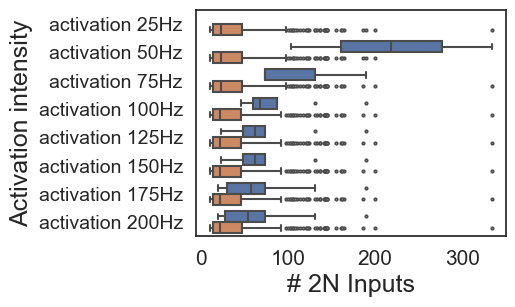

In [133]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="bitter_syn_count", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

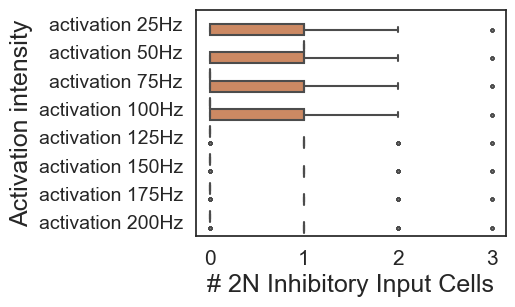

In [134]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="inhibitory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

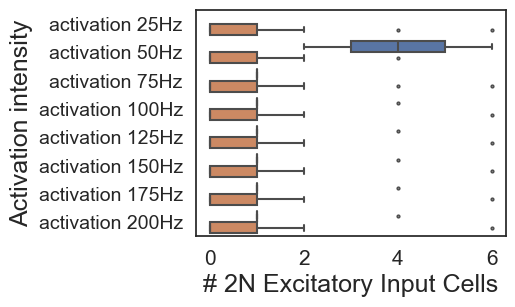

In [135]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="excitatory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

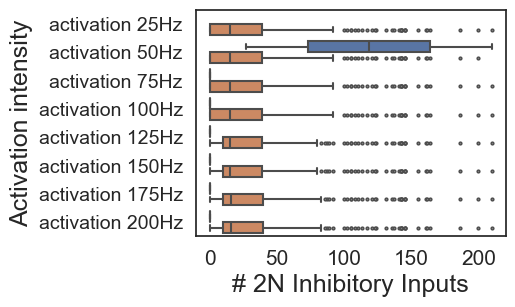

In [136]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

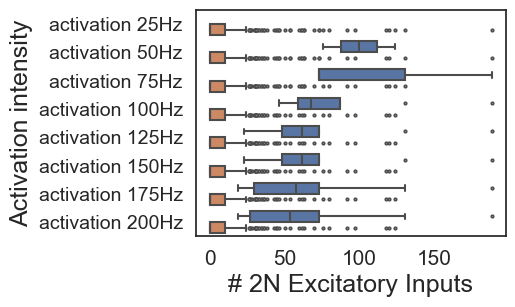

In [137]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="excitatory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

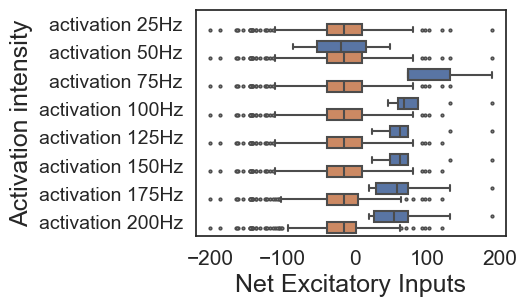

In [138]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=bitter_activation_vertically_stacked_3N, x="excitatory - inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

### Low salt plots

In [139]:
lowsalt_activation_25Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_25Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_25Hz_3N['label'] = 'activation 25Hz'
lowsalt_activation_50Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_50Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_50Hz_3N['label'] = 'activation 50Hz'
lowsalt_activation_75Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_75Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_75Hz_3N['label'] = 'activation 75Hz'
lowsalt_activation_100Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_100Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_100Hz_3N['label'] = 'activation 100Hz'
lowsalt_activation_125Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_125Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_125Hz_3N['label'] = 'activation 125Hz'
lowsalt_activation_150Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_150Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_150Hz_3N['label'] = 'activation 150Hz'
lowsalt_activation_175Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_175Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_175Hz_3N['label'] = 'activation 175Hz'
lowsalt_activation_200Hz_3N = pd.concat([lowsalt_3Ns.iloc[:,0:12], lowsalt_3Ns['activation_200Hz'], lowsalt_3Ns['excitatory - inhibitory_number_input_synapse']], axis=1)
lowsalt_activation_200Hz_3N['label'] = 'activation 200Hz'

lowsalt_activation_vertically_stacked_3N = pd.concat([lowsalt_activation_25Hz_3N,lowsalt_activation_50Hz_3N,lowsalt_activation_75Hz_3N,lowsalt_activation_100Hz_3N,lowsalt_activation_125Hz_3N,lowsalt_activation_150Hz_3N,lowsalt_activation_175Hz_3N,lowsalt_activation_200Hz_3N], axis=0)
cols_merge_activation_level = ['activation_25Hz', "activation_50Hz", "activation_75Hz","activation_100Hz","activation_125Hz","activation_150Hz","activation_175Hz","activation_200Hz"]
lowsalt_activation_vertically_stacked_3N['activation'] = lowsalt_activation_vertically_stacked_3N['activation_25Hz'].fillna('') + lowsalt_activation_vertically_stacked_3N['activation_50Hz'].fillna('')+ lowsalt_activation_vertically_stacked_3N['activation_75Hz'].fillna('')+ lowsalt_activation_vertically_stacked_3N['activation_100Hz'].fillna('')+lowsalt_activation_vertically_stacked_3N['activation_125Hz'].fillna('')+lowsalt_activation_vertically_stacked_3N['activation_150Hz'].fillna('')+lowsalt_activation_vertically_stacked_3N['activation_175Hz'].fillna('')+lowsalt_activation_vertically_stacked_3N['activation_200Hz'].fillna('')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

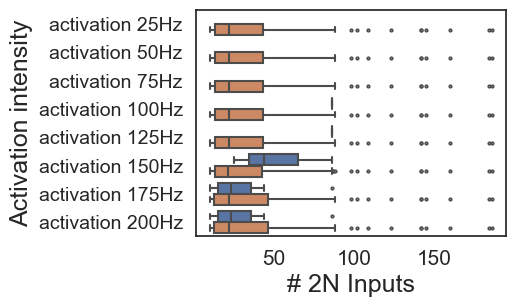

In [140]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="lowsalt_syn_count", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

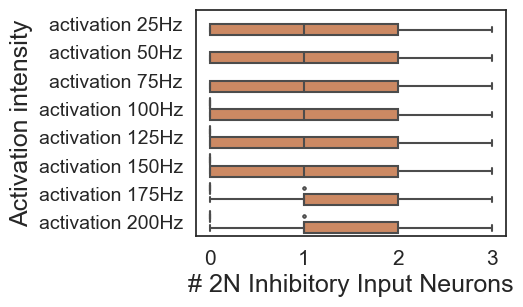

In [141]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="inhibitory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Neurons', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

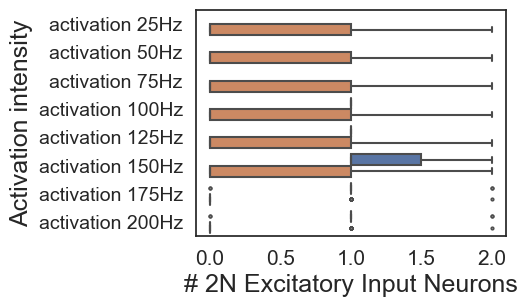

In [142]:
plt.subplots(figsize = (4,3))
ax =sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="excitatory_number_upstream_neurons", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Neurons', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

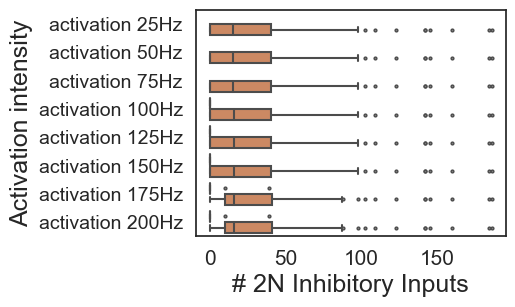

In [143]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

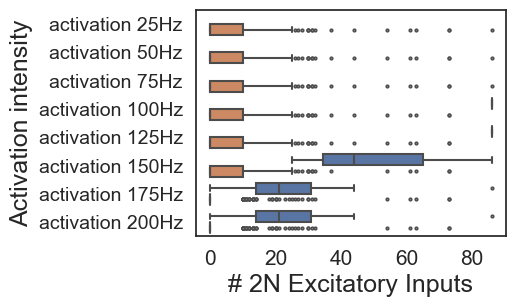

In [144]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="excitatory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'activation 25Hz'),
  Text(0, 1, 'activation 50Hz'),
  Text(0, 2, 'activation 75Hz'),
  Text(0, 3, 'activation 100Hz'),
  Text(0, 4, 'activation 125Hz'),
  Text(0, 5, 'activation 150Hz'),
  Text(0, 6, 'activation 175Hz'),
  Text(0, 7, 'activation 200Hz')])

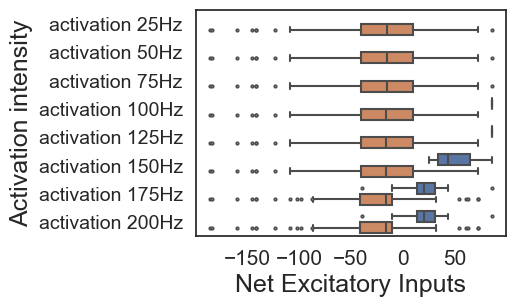

In [145]:
plt.subplots(figsize = (4,3))
ax = sns.boxplot(data=lowsalt_activation_vertically_stacked_3N, x="excitatory - inhibitory_number_input_synapse", y = 'label', hue="activation",hue_order = ['activated', 'non activated'],flierprops={"marker": "o", 'markersize': 2, 'markerfacecolor': 'grey'})
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)

### Print median excitatory synapse values

In [146]:
print('sugar:',sugar_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('water:',water_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('bitter:',bitter_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Ir94e:',lowsalt_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())

sugar: activation     label           
activated      activation 100Hz    40.5
               activation 125Hz    40.0
               activation 150Hz    37.5
               activation 175Hz    35.5
               activation 200Hz    34.0
               activation 25Hz     83.0
               activation 50Hz     44.5
               activation 75Hz     41.0
non activated  activation 100Hz     0.0
               activation 125Hz     0.0
               activation 150Hz     0.0
               activation 175Hz     0.0
               activation 200Hz     0.0
               activation 25Hz      0.0
               activation 50Hz      0.0
               activation 75Hz      0.0
Name: excitatory_number_input_synapse, dtype: float64
water: activation     label           
activated      activation 100Hz     52.0
               activation 125Hz     46.0
               activation 150Hz     42.0
               activation 175Hz     39.0
               activation 200Hz     34.0
               activati

### Print median net excitation values

In [147]:
print('sugar:',sugar_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('water:',water_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('bitter:',bitter_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Ir94e:',lowsalt_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())

sugar: activation     label           
activated      activation 100Hz    31.5
               activation 125Hz    32.0
               activation 150Hz    31.0
               activation 175Hz    30.5
               activation 200Hz    30.5
               activation 25Hz     79.0
               activation 50Hz     37.5
               activation 75Hz     32.5
non activated  activation 100Hz   -12.0
               activation 125Hz   -12.0
               activation 150Hz   -13.0
               activation 175Hz   -13.0
               activation 200Hz   -13.0
               activation 25Hz    -10.0
               activation 50Hz    -12.0
               activation 75Hz    -12.0
Name: excitatory - inhibitory_number_input_synapse, dtype: float64
water: activation     label           
activated      activation 100Hz     52.0
               activation 125Hz     44.0
               activation 150Hz     39.0
               activation 175Hz     38.0
               activation 200Hz     33.0
          

### Plot how many 3Ns were activated by GRN stimulation

In [148]:
sugar_df_activation_3N = pd.concat([pd.DataFrame(sugar_activation_25Hz_3N.activation_25Hz.value_counts()),
           pd.DataFrame(sugar_activation_50Hz_3N.activation_50Hz.value_counts()),
           pd.DataFrame(sugar_activation_75Hz_3N.activation_75Hz.value_counts()),
           pd.DataFrame(sugar_activation_100Hz_3N.activation_100Hz.value_counts()),
           pd.DataFrame(sugar_activation_125Hz_3N.activation_125Hz.value_counts()),
           pd.DataFrame(sugar_activation_150Hz_3N.activation_150Hz.value_counts()),
           pd.DataFrame(sugar_activation_175Hz_3N.activation_175Hz.value_counts()),
           pd.DataFrame(sugar_activation_200Hz_3N.activation_200Hz.value_counts())]
          , axis = 1)

water_df_activation_3N = pd.concat([pd.DataFrame(water_activation_25Hz_3N.activation_25Hz.value_counts()),
           pd.DataFrame(water_activation_50Hz_3N.activation_50Hz.value_counts()),
           pd.DataFrame(water_activation_75Hz_3N.activation_75Hz.value_counts()),
           pd.DataFrame(water_activation_100Hz_3N.activation_100Hz.value_counts()),
           pd.DataFrame(water_activation_125Hz_3N.activation_125Hz.value_counts()),
           pd.DataFrame(water_activation_150Hz_3N.activation_150Hz.value_counts()),
           pd.DataFrame(water_activation_175Hz_3N.activation_175Hz.value_counts()),
           pd.DataFrame(water_activation_200Hz_3N.activation_200Hz.value_counts())]
          , axis = 1)

bitter_df_activation_3N = pd.concat([pd.DataFrame(bitter_activation_25Hz_3N.activation_25Hz.value_counts()),
           pd.DataFrame(bitter_activation_50Hz_3N.activation_50Hz.value_counts()),
           pd.DataFrame(bitter_activation_75Hz_3N.activation_75Hz.value_counts()),
           pd.DataFrame(bitter_activation_100Hz_3N.activation_100Hz.value_counts()),
           pd.DataFrame(bitter_activation_125Hz_3N.activation_125Hz.value_counts()),
           pd.DataFrame(bitter_activation_150Hz_3N.activation_150Hz.value_counts()),
           pd.DataFrame(bitter_activation_175Hz_3N.activation_175Hz.value_counts()),
           pd.DataFrame(bitter_activation_200Hz_3N.activation_200Hz.value_counts())]
          , axis = 1)

lowsalt_df_activation_3N = pd.concat([pd.DataFrame(lowsalt_activation_25Hz_3N.activation_25Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_50Hz_3N.activation_50Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_75Hz_3N.activation_75Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_100Hz_3N.activation_100Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_125Hz_3N.activation_125Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_150Hz_3N.activation_150Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_175Hz_3N.activation_175Hz.value_counts()),
           pd.DataFrame(lowsalt_activation_200Hz_3N.activation_200Hz.value_counts())]
          , axis = 1)

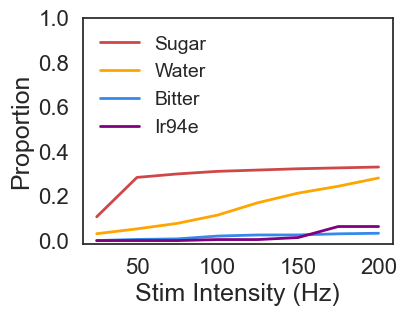

In [149]:
input_intensity = [25,50,75,100,125,150,175,200]

y_sugar_3N = sugar_df_activation_3N.values[1,:] / (sugar_df_activation_3N.values[0,:]+ sugar_df_activation_3N.values[1,:])
y_water_3N = water_df_activation_3N.values[1,:] / (water_df_activation_3N.values[0,:]+ water_df_activation_3N.values[1,:])
y_bitter_3N = bitter_df_activation_3N.values[1,:] / (bitter_df_activation_3N.values[0,:]+ bitter_df_activation_3N.values[1,:])
y_lowsalt_3N = lowsalt_df_activation_3N.values[1,:] / (lowsalt_df_activation_3N.values[0,:]+ lowsalt_df_activation_3N.values[1,:])

y_modalities_3N = [y_sugar_3N, y_water_3N, y_bitter_3N, y_lowsalt_3N] 

labels_3N = ["Sugar", "Water", "Bitter","Ir94e"]

fig, ax = plt.subplots(figsize=(4, 3))


# Define a nice color palette:
colors = ['#cf4848', 'orange', '#3489eb','purple']

# Plot each of the main lines
for i, label in enumerate(labels_3N):
    # Line
    ax.plot(input_intensity , np.nan_to_num(y_modalities_3N[i]), label=label, color=colors[i], linewidth=2)

ax.set_xlabel("Stim Intensity (Hz)", size=18)
ax.set_ylabel("Proportion", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_yticks(np.arange(0, 1.1, step=0.2))
ax.legend(frameon=False, fontsize=14, loc='upper left')
#plt.title("Proportion of 3Ns activated")
plt.show()

In [150]:
# get numbers - note zeros show up as NaNs
print(y_sugar_3N)
print(y_water_3N)
print(y_bitter_3N)
print(y_lowsalt_3N)

[0.10679612 0.28349515 0.29902913 0.31067961 0.31650485 0.3223301
 0.32621359 0.33009709]
[0.0308642  0.05246914 0.07716049 0.11419753 0.16975309 0.21296296
 0.24382716 0.2808642 ]
[       nan 0.00505051 0.00757576 0.02020202 0.02525253 0.02525253
 0.03030303 0.03282828]
[       nan        nan        nan 0.0045045  0.0045045  0.01351351
 0.06306306 0.06306306]


## 3d. Analyze 3N inputs and convergence across modalities


### Venn diagram to visualize convergence of 2N modalities onto 3Ns

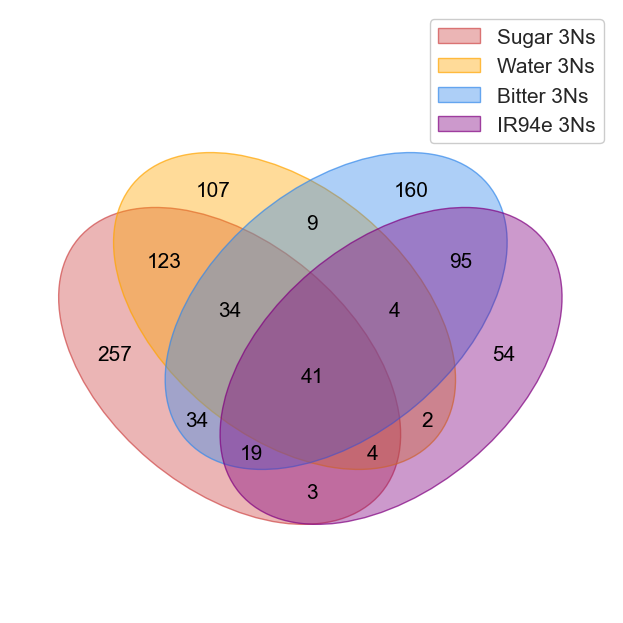

In [151]:
sugar_list = {'{}'.format(value) for value in sugar_3Ns['root_id'].unique()}
sugar_dict = {'Sugar 3Ns': sugar_list}

water_list = {'{}'.format(value) for value in water_3Ns['root_id'].unique()}
water_dict = {'Water 3Ns': water_list}


bitter_list = {'{}'.format(value) for value in bitter_3Ns['root_id'].unique()}
bitter_dict = {'Bitter 3Ns': bitter_list}

lowsalt_list = {'{}'.format(value) for value in lowsalt_3Ns['root_id'].unique()}
lowsalt_dict = {'IR94e 3Ns': lowsalt_list}

colors = ('#cf4848','orange','#3489eb','purple')
crossover = {**sugar_dict, **water_dict, **bitter_dict, **lowsalt_dict}
venn(crossover, cmap = ListedColormap(colors), figsize = (8,8), fontsize = 15)
plt.show()

### Make heatmap to see 2N-3N connectivity to individual 3Ns

We will plot each individual 3N as a different column and each 2N modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of 2Ns onto each 3N. Note that the same 2N cells may be represented in multiple categories (rows). 

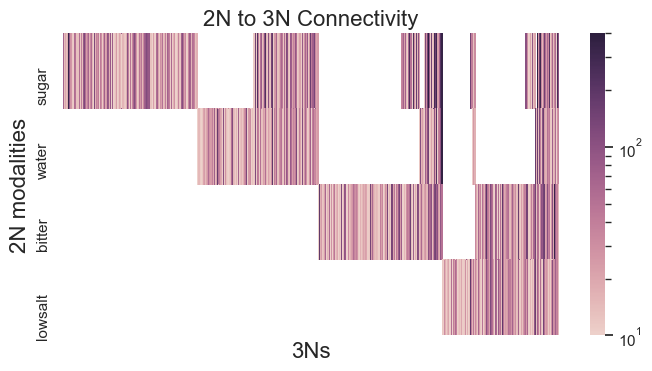

In [152]:
# Concatenate 2N-3N connectivity matrices
heatmap_data = pd.concat([sugar_third_order_connectivity,water_third_order_connectivity,bitter_third_order_connectivity,lowsalt_third_order_connectivity], 
                    keys = ['sugar','water','bitter', 'lowsalt'],
                    names = ['modality','neuron_id'],
                    axis = 0)

# Aggregate synaptic count over neuropil and NT type and pre_root_ID
# Then unshape and fill nulls with zeros
syn_count_by_modality = heatmap_data.groupby(
    ['modality', 'post_root_id'])['syn_count'].sum().unstack().fillna(0).astype(int)

# Set order for displaying 3Ns
isnonzero = syn_count_by_modality == 0
display_order_3Ns = isnonzero.T.sort_values(['post_root_id', 'sugar','water','bitter','lowsalt'][::-1], ascending=False).index
syn_count_by_modality = syn_count_by_modality.loc[['sugar','water','bitter','lowsalt'], display_order_3Ns]

# Display heatmap
# Note that the way the lines display may be limited by pixel resolution, due to large # of columns
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(syn_count_by_modality, norm=LogNorm(),cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('2N to 3N Connectivity', size=16)
plt.xlabel('3Ns', size=16)
plt.ylabel('2N modalities', size=16)
plt.show()

## 3e. Analyze 2N-3N inputs within a modality

### Add a column for # 2N input synapses and % of total input coming from 2Ns

In [153]:
# % input to each 3N from 2Ns (as a % of total input the 3N receives)
# This was used for analyses that are not included in the paper
sugar_3Ns['%_sugar_input'] = sugar_3Ns['sugar_syn_count']/sugar_3Ns['input_synapses']*100
water_3Ns['%_water_input'] = water_3Ns['water_syn_count']/water_3Ns['input_synapses']*100
bitter_3Ns['%_bitter_input'] = bitter_3Ns['bitter_syn_count']/bitter_3Ns['input_synapses']*100
lowsalt_3Ns['%_lowsalt_input'] = lowsalt_3Ns['lowsalt_syn_count']/lowsalt_3Ns['input_synapses']*100

In [154]:
# Average number of synapses each 3N receives per 2N, considering only 2Ns of the same modality
# This is used in the scatter plots below
sugar_3Ns['avg_upstream_synapses'] = sugar_3Ns['sugar_syn_count']/sugar_3Ns['upstream_sugar_2Ns']
water_3Ns['avg_upstream_synapses'] = water_3Ns['water_syn_count']/water_3Ns['upstream_water_2Ns']
bitter_3Ns['avg_upstream_synapses'] = bitter_3Ns['bitter_syn_count']/bitter_3Ns['upstream_bitter_2Ns']
lowsalt_3Ns['avg_upstream_synapses'] = lowsalt_3Ns['lowsalt_syn_count']/lowsalt_3Ns['upstream_lowsalt_2Ns']

In [155]:
# inspect dataframe
sugar_3Ns

,root_id,upstream_sugar_2Ns,sugar_syn_count,const,nt_type,side,input_synapses,output_synapses,excitatory_number_upstream_neurons,inhibitory_number_upstream_neurons,...,label,activation_50Hz,activation_75Hz,activation_100Hz,activation_125Hz,activation_150Hz,activation_175Hz,activation_200Hz,%_sugar_input,avg_upstream_synapses
0,720575940604030566,2,24,1,ACH,right,76.0,271.0,0,2,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,31.578947,12.000000
1,720575940605282406,1,17,1,ACH,right,286.0,138.0,0,1,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,5.944056,17.000000
2,720575940605658033,1,23,1,NaN,right,2109.0,0.0,1,0,...,sugar,activated,activated,activated,activated,activated,activated,activated,1.090564,23.000000
3,720575940606421122,1,13,1,GABA,right,1077.0,1276.0,1,0,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,1.207057,13.000000
4,720575940606567125,3,75,1,ACH,left,123.0,323.0,0,3,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,60.975610,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,720575940659340673,2,69,1,GABA,left,1158.0,2091.0,2,0,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,5.958549,34.500000
511,720575940660223873,3,55,1,ACH,left,1407.0,2354.0,3,0,...,sugar,activated,activated,activated,activated,activated,activated,activated,3.909026,18.333333
512,720575940660229505,3,149,1,NaN,right,2666.0,0.0,3,0,...,sugar,activated,activated,activated,activated,activated,activated,activated,5.588897,49.666667
513,720575940660233601,1,10,1,GABA,left,1056.0,2040.0,0,1,...,sugar,non activated,non activated,non activated,non activated,non activated,non activated,non activated,0.946970,10.000000


### Comparing the # input cells and the # synapses per input cell for each 3N (within a modality)

First we will make scatter plots comparing these variables for each modality.

Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.

We will also report the median number of 2N input synapses and 2N input cells per 3N.

In [156]:
# define a function to plot a scatter plot of # input 2Ns versus # synapses per 2N
# the function also fits a line to the data
def synapse_scatter_3Ns(taste_3Ns, taste, color, title):
    
    # define x and y data
    x = taste_3Ns['upstream_' + taste + '_2Ns']
    y = taste_3Ns['avg_upstream_synapses']
    
    # define line to be fit
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    
    # make plot
    fig, ax = plt.subplots(figsize = (4,3))
    sns.scatterplot(data=taste_3Ns, x='upstream_' + taste + '_2Ns', y="avg_upstream_synapses", color = color)
    x_line = np.arange(0, max(x)+1, 1)
    y_line = objective(x_line, a, b)
    
    ax.plot(x_line, y_line, '--', color='black')
    ax.set_xticks(np.arange(0, max(x) + 1.5, step=1))
    ax.set_yticks(np.arange(0, max(y) + 5, step=50))
    ax.set_xlabel('# Input 2Ns', fontsize=18)
    ax.set_ylabel('# Synapses per 2N', fontsize=18)
    #ax.set_title('Convergence Within ' + title + ' 3Ns')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    formula = ('y = %.5f * x + %.5f ' % (a, b))
    
    return formula

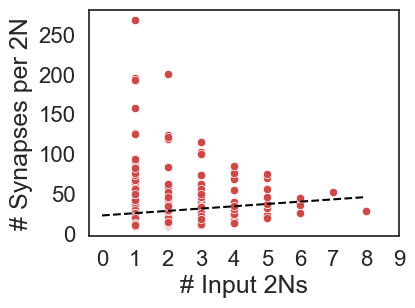

'y = 2.88068 * x + 23.14837 '

In [157]:
synapse_scatter_3Ns(sugar_3Ns, 'sugar', '#cf4848', 'Sugar')

In [158]:
# OLS regression for sugar
sugar_model = sm.OLS(sugar_3Ns['avg_upstream_synapses'], sugar_3Ns[['const','upstream_sugar_2Ns']]).fit()

# median number of sugar 2Ns providing input to a sugar 3N
print(np.median(sugar_3Ns['upstream_sugar_2Ns']))

# median number of sugar GRN synapses providing input to sugar 2N 
print(np.median(sugar_3Ns['sugar_syn_count']))

# the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(sugar_model.pvalues[1])

sugar_model.summary()

1.0
29.0
0.005023070330509522


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.013
Method:                    Least Squares   F-statistic:                     7.940
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):            0.00502
Time:                           14:49:09   Log-Likelihood:                -2438.6
No. Observations:                    515   AIC:                             4881.
Df Residuals:                        513   BIC:                             4890.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 23.1484      2.214     10.454      0.000      18.798      27.499
upstream_sugar_2Ns     2.8807      1.022      2.818      0.005       0.872       4.889
==============================================================================
Omnibus:                      474.864   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12686.064
Skew:                           4.100   Prob(JB):                         0.00
Kurtosis:                      25.890   Cond. No.                         4.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

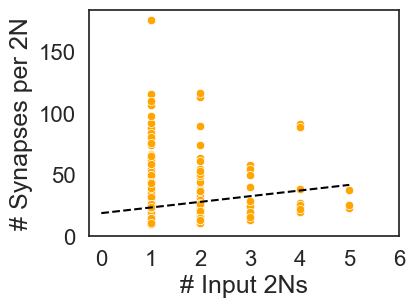

'y = 4.59407 * x + 18.81815 '

In [159]:
synapse_scatter_3Ns(water_3Ns, 'water', 'orange','Water')

In [160]:
# OLS regression for water
water_model = sm.OLS(water_3Ns['avg_upstream_synapses'], water_3Ns[['const','upstream_water_2Ns']]).fit()

# median number of 2Ns providing input to a 3N
print(np.median(water_3Ns['upstream_water_2Ns']))

# median number of 2N synapses providing input to 3N 
print(np.median(water_3Ns['water_syn_count']))

# the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(water_model.pvalues[1])

water_model.summary()

1.0
22.0
0.004879888025062798


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.024
Model:                               OLS   Adj. R-squared:                  0.021
Method:                    Least Squares   F-statistic:                     8.034
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):            0.00488
Time:                           14:49:10   Log-Likelihood:                -1455.9
No. Observations:                    324   AIC:                             2916.
Df Residuals:                        322   BIC:                             2923.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 18.8182      2.563      7.343      0.000      13.776      23.860
upstream_water_2Ns     4.5941      1.621      2.834      0.005       1.405       7.783
==============================================================================
Omnibus:                      228.614   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2167.933
Skew:                           2.949   Prob(JB):                         0.00
Kurtosis:                      14.216   Cond. No.                         4.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

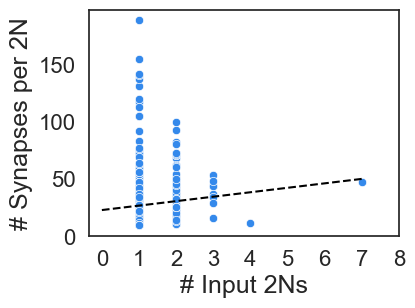

'y = 3.89033 * x + 22.89132 '

In [161]:
synapse_scatter_3Ns(bitter_3Ns, 'bitter', '#3489eb','Bitter')

In [162]:
# OLS regression for bitter
bitter_model = sm.OLS(bitter_3Ns['avg_upstream_synapses'], bitter_3Ns[['const','upstream_bitter_2Ns']]).fit()

# median number of 2Ns providing input to a 3N
print(np.median(bitter_3Ns['upstream_bitter_2Ns']))

# median number of 2N synapses providing input to 3N 
print(np.median(bitter_3Ns['bitter_syn_count']))

# the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(bitter_model.pvalues[1])

bitter_model.summary()

1.0
23.0
0.0726864165916398


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     3.239
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):             0.0727
Time:                           14:49:10   Log-Likelihood:                -1840.0
No. Observations:                    396   AIC:                             3684.
Df Residuals:                        394   BIC:                             3692.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  22.8913      3.105      7.372      0.000      16.787      28.996
upstream_bitter_2Ns     3.8903      2.162      1.800      0.073      -0.360       8.140
==============================================================================
Omnibus:                      254.846   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2018.206
Skew:                           2.764   Prob(JB):                         0.00
Kurtosis:                      12.579   Cond. No.                         5.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

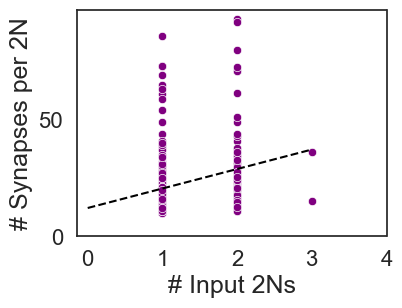

'y = 8.35650 * x + 12.12130 '

In [163]:
synapse_scatter_3Ns(lowsalt_3Ns, 'lowsalt', 'purple','IR94e')

In [164]:
# OLS regression for lowsalt
lowsalt_model = sm.OLS(lowsalt_3Ns['avg_upstream_synapses'], lowsalt_3Ns[['const','upstream_lowsalt_2Ns']]).fit()

# median number of 2Ns providing input to a 3N
print(np.median(lowsalt_3Ns['upstream_lowsalt_2Ns']))

# median number of 2N synapses providing input to 3N 
print(np.median(lowsalt_3Ns['lowsalt_syn_count']))

# the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0 
print(lowsalt_model.pvalues[1])

lowsalt_model.summary()

1.0
22.0
0.00020586579024724452


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avg_upstream_synapses   R-squared:                       0.061
Model:                               OLS   Adj. R-squared:                  0.057
Method:                    Least Squares   F-statistic:                     14.25
Date:                   Sat, 14 Sep 2024   Prob (F-statistic):           0.000206
Time:                           14:49:11   Log-Likelihood:                -933.15
No. Observations:                    222   AIC:                             1870.
Df Residuals:                        220   BIC:                             1877.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.1213      3.166      3.829      0.000       5.882      18.360
upstream_lowsalt_2Ns     8.3565      2.214      3.775      0.000       3.994      12.719
==============================================================================
Omnibus:                      100.757   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.733
Skew:                           2.020   Prob(JB):                     4.08e-67
Kurtosis:                       7.091   Cond. No.                         6.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot distribution of 2N-3N connection strength

We are quantifying the total number of 2N input synapses that each 3N receives, and looking at the distribution across all 3Ns.

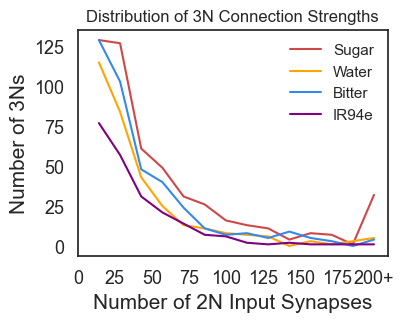

In [165]:
# define a function to get the synapse distribution
bins = np.linspace(0,200,15)
def synapse_distribution_3Ns(taste_3Ns, taste):
    data = taste_3Ns[taste + '_syn_count']
    frequencies, bin_edges = np.histogram(np.clip(data,0,200), bins) #clipping the data at 200
    bin_labels = bins[1:]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies' : frequencies})
    return df

# calculate synapse distribution for each modality
sugar_synapse_distribution = synapse_distribution_3Ns(sugar_3Ns, 'sugar')
water_synapse_distribution = synapse_distribution_3Ns(water_3Ns, 'water')
bitter_synapse_distribution = synapse_distribution_3Ns(bitter_3Ns, 'bitter')
lowsalt_synapse_distribution = synapse_distribution_3Ns(lowsalt_3Ns, 'lowsalt')

# organize data and parameters for plotting
dataframes = [sugar_synapse_distribution, water_synapse_distribution, bitter_synapse_distribution, lowsalt_synapse_distribution]
labels = ['Sugar', 'Water', 'Bitter', 'IR94e']
colors = ['#cf4848', 'orange', '#3489eb','purple']

# make plot
plt.figure(figsize=(4,3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 25, 50, 75, 100, 125, 150, 175, 200]
xlabels = ['0', '25', '50', '75', '100', '125', '150', '175', '200+']
plt.xticks(xticks, xlabels, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Number of 2N Input Synapses', fontsize=15)
plt.ylabel('Number of 3Ns', fontsize=15)
plt.title('Distribution of 3N Connection Strengths')
plt.legend(frameon=False)
plt.show()

## 3f. Classifying 3Ns by their anatomical and functional properties

### Defining 3Ns as local vs. non-local neurons

Local refers to 3Ns whose output connections are entirely within the SEZ; non-local refers to 3Ns with at least one connection outside the SEZ. The code refers to non-local neurons as "projection neurons" but we changed the terminology in the paper because some non-local neurons may reside entirely outside of the SEZ rather than projecting from the SEZ to other regions.

In [166]:
# Use the same function as defined earlier for 2Ns, but we are saving the result as a new dataframe
sugar_3Ns_categorized = pd.merge(sugar_3Ns, classify_neurons(sugar_3Ns), on = 'root_id')
water_3Ns_categorized = pd.merge(water_3Ns, classify_neurons(water_3Ns), on = 'root_id')
bitter_3Ns_categorized = pd.merge(bitter_3Ns, classify_neurons(bitter_3Ns), on = 'root_id')
lowsalt_3Ns_categorized = pd.merge(lowsalt_3Ns, classify_neurons(lowsalt_3Ns), on = 'root_id')

In [167]:
# Print numbers of 3Ns that are categorized in new dataframes
# Note that some 3Ns are excluded because they had no postsynaptic sites (mostly efferent or motor neurons)
print(np.unique(sugar_3Ns_categorized.root_id.values).shape)
print(np.unique(water_3Ns_categorized.root_id.values).shape)
print(np.unique(bitter_3Ns_categorized.root_id.values).shape)
print(np.unique(lowsalt_3Ns_categorized.root_id.values).shape)

(482,)
(317,)
(391,)
(219,)


In [168]:
#save 3N lists as csv files: all 3Ns as well as categorized list that omits some 3Ns
sugar_3Ns.to_csv('sugar_3Ns.csv')
water_3Ns.to_csv('water_3Ns.csv')
bitter_3Ns.to_csv('bitter_3Ns.csv')
lowsalt_3Ns.to_csv('lowsalt_3Ns.csv')
sugar_3Ns_categorized.to_csv('sugar_3Ns_categorized.csv')
water_3Ns_categorized.to_csv('water_3Ns_categorized.csv')
bitter_3Ns_categorized.to_csv('bitter_3Ns_categorized.csv')
lowsalt_3Ns_categorized.to_csv('lowsalt_3Ns_categorized.csv')

### Comparing the number of local vs. non-local 3Ns across modalities

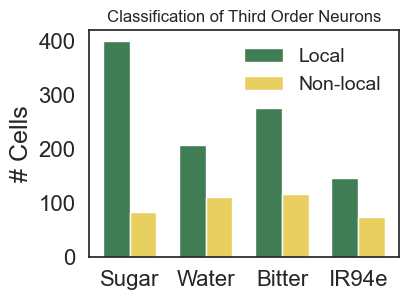

In [169]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar_3Ns_categorized, water_3Ns_categorized, bitter_3Ns_categorized, lowsalt_3Ns_categorized]

local_neurons = []
projection_neurons = []

for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))
    chi_3N_neurons = [local_neurons, projection_neurons]

x = range(len(categories))
bar_width = 0.35

plt.figure(figsize = (4,3))
plt.bar(x, local_neurons, width=bar_width,label = "Local", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_neurons, width=bar_width, label = "Non-local", color = '#e8cf5f')

plt.ylabel('# Cells', size=18)
plt.title('Classification of Third Order Neurons')
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [170]:
# Show numbers of local and projection neurons
print(local_neurons)
print(projection_neurons)

[399, 206, 275, 146]
[83, 111, 116, 73]


### Get output synapses of 3Ns to analyze location and NT types
- includes any outputs of a 3N
- minimum of 5 synapses
- we are not filtering out postsynaptic targets that are also GRNs, 2Ns, or 3Ns

In [171]:
# Uses the same function we defined earlier for GRN and 2N outputs
sugar3N_outputs = neuronal_outputs(sugar_3Ns)
water3N_outputs = neuronal_outputs(water_3Ns)
bitter3N_outputs = neuronal_outputs(bitter_3Ns)
lowsalt3N_outputs = neuronal_outputs(lowsalt_3Ns)

### Comparing the number of 3N output synapses within vs. outside the SEZ across modalities

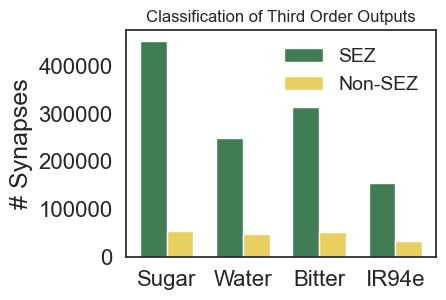

In [172]:
categories = ['Sugar','Water','Bitter','IR94e']
datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())
    chi_3N_synapses = [local_synapses, projection_synapses]
    
x = range(len(categories))

bar_width = 0.35

plt.figure(figsize = (4,3))
plt.bar(x, local_synapses, width=bar_width,label = "SEZ", color = '#407d55')
plt.bar([i+ bar_width for i in x], projection_synapses, width=bar_width, label = "Non-SEZ", color = '#e8cf5f')

plt.ylabel('# Synapses', fontsize=18)
plt.title('Classification of Third Order Outputs')
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [173]:
# Show numbers of local and non-local synapses
print(local_synapses)
print(projection_synapses)

[451267, 248525, 312632, 155160]
[54435, 47355, 52773, 33467]


### Quantify the neurotransmitter types for local and projection 3N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 3N synapses.

Note that this analysis quantifies 3N outputs by the number of connections, not synapses.

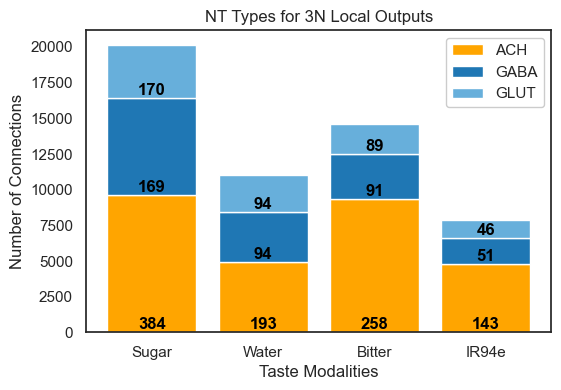

In [174]:
# Start with local neurons/outputs

NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

# Run the functions defined in the 2N section
variables = count_NTs_local(datasets, categories)
neurons = count_neurons_local(datasets, categories)

# Make plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 3N Local Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

In [175]:
# Show numbers of outputs for each NT type
variables

(array([9602, 4918, 9353, 4780]),
 array([6796, 3502, 3150, 1824]),
 array([3755, 2630, 2062, 1287]))

(array([    0.,  5000., 10000., 15000., 20000., 25000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

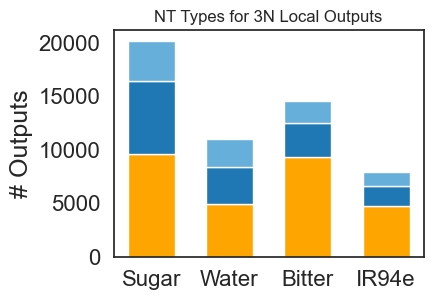

In [176]:
# Make same figures as above but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
#ax.legend(NTs, frameon=False, loc = 'upper right')
ax.set_title('NT Types for 3N Local Outputs')
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

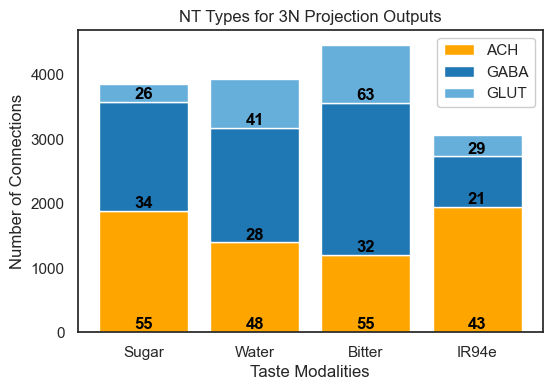

In [177]:
# Now do projection neurons/outputs

NTs = ['ACH','GABA','GLUT']
categories = ['Sugar','Water','Bitter','IR94e']

datasets = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

# Run the functions defined in the 2N section
variables = count_NTs_proj(datasets, categories)
neurons = count_neurons_proj(datasets, categories)

# Make plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.8
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('Number of Connections')
ax.set_xlabel('Taste Modalities')
ax.legend(NTs)
ax.set_title('NT Types for 3N Projection Outputs')
plt.xticks(tick_pos, categories)

for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3, neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, n1, ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, n2, ha="center", va="bottom", color="black",  fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 , n3, ha="center", va="bottom", color="black",  fontweight="bold")


plt.show()

In [178]:
# Show numbers of outputs for each NT type
variables

(array([1890, 1395, 1205, 1953]),
 array([1688, 1783, 2359,  778]),
 array([281, 753, 904, 327]))

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

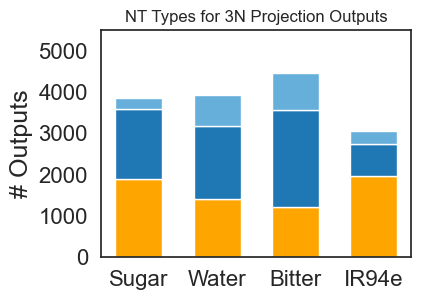

In [179]:
# Same fig as above but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 3N Projection Outputs')
#ax.legend(NTs, frameon=False, loc = 'upper right')
ax.set_ylim([0, 5500])
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

### Quantify ipsilateral vs. contralateral 3N outputs

In [180]:
# Classify ipsi vs contra side for each output using function defined in the 2N section
sugar3N_outputs['hemisphere'] = sugar3N_outputs['neuropil'].apply(bilateral)
water3N_outputs['hemisphere'] = water3N_outputs['neuropil'].apply(bilateral)
bitter3N_outputs['hemisphere'] = bitter3N_outputs['neuropil'].apply(bilateral)
lowsalt3N_outputs['hemisphere'] = lowsalt3N_outputs['neuropil'].apply(bilateral)

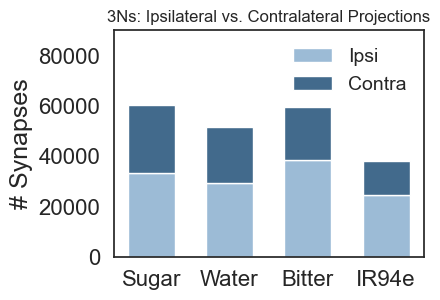

In [181]:
# Plot number of ipsi vs. contra output synapses for 3Ns
third_order_outputs = [sugar3N_outputs, water3N_outputs, bitter3N_outputs, lowsalt3N_outputs]

ipsilateral = []
contralateral = []

for entry in third_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['Sugar', 'Water', 'Bitter', 'IR94e']
brain_hemisphere = ['Ipsi', 'Contra']

bar_width = 0.6
plt.figure(figsize=(4,3))
plt.bar(categories, ipsilateral, color = '#9cbbd6', width = bar_width)
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c', width = bar_width)
ax = plt.gca()
ax.set_ylim([0, 90000])
plt.title('3Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(brain_hemisphere, frameon=False, fontsize=14, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [182]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

[33430, 29377, 38616, 24612]
[26718, 22084, 20765, 13433]


### Quantify 3N projections to each brain region
### Start by consolidating bilateral brain regions for second order outputs

In [183]:
# apply the same remapping as done for 2Ns to consolidate regions including L and R sides
sugar3N_outputs['neuropil_remap'] = sugar3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
water3N_outputs['neuropil_remap'] = water3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
bitter3N_outputs['neuropil_remap'] = bitter3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
lowsalt3N_outputs['neuropil_remap'] = lowsalt3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Make bar graphs of brain regions with 3N output synapses

In [184]:
# Determine the top 12 non-SEZ brain regions for 3N outputs for each modality using function defined earlier

sugar3N_top12 = get_top12_regions(sugar3N_outputs)
water3N_top12 = get_top12_regions(water3N_outputs)
bitter3N_top12 = get_top12_regions(bitter3N_outputs)
lowsalt3N_top12 = get_top12_regions(lowsalt3N_outputs)

print(sugar3N_top12)
print(water3N_top12)
print(bitter3N_top12)
print(lowsalt3N_top12)

['AL', 'SMP', 'SCL', 'WED', 'PVLP', 'LH', 'IPS', 'SPS', 'LAL', 'SLP', 'AVLP', 'VES']
['MB_CA', 'SPS', 'VES', 'PLP', 'AVLP', 'AL', 'SMP', 'GOR', 'SCL', 'LH', 'ICL', 'SLP']
['IPS', 'MB_CA', 'SCL', 'WED', 'VES', 'SPS', 'SIP', 'PVLP', 'AVLP', 'SMP', 'LH', 'SLP']
['PLP', 'ICL', 'IB', 'CRE', 'AVLP', 'SIP', 'LAL', 'VES', 'SCL', 'LH', 'SMP', 'SLP']


In [185]:
# make a list of regions in the top 12 for any modality
all_regions_3Ns = list(
    set(sugar3N_top12) | set(water3N_top12) | set(bitter3N_top12) | set(lowsalt3N_top12))

all_regions_3Ns

['LH',
 'IB',
 'MB_CA',
 'LAL',
 'ICL',
 'AVLP',
 'AL',
 'WED',
 'PLP',
 'SIP',
 'SLP',
 'SMP',
 'VES',
 'SPS',
 'IPS',
 'PVLP',
 'CRE',
 'GOR',
 'SCL']

In [186]:
# Define custom order of brain regions above (for plotting)
categories = ['SMP','SIP','SLP', 
               'SCL','ICL','CRE','IB',
               'AL', 'LH','MB_CA',
               'AVLP','PVLP','PLP','WED',
               'VES', 'GOR','SPS','IPS','LAL']

# Define NTs
NTs = ['ACH','GABA','GLUT','DA', 'SER']

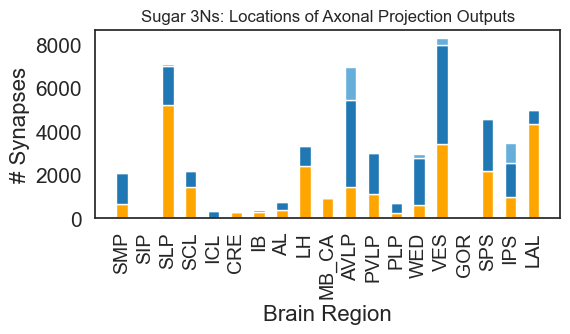

In [187]:
# Make bar graph showing outputs of sugar 3Ns, colored by NT type

datasets = []
for category in categories:
    counts = pd.DataFrame(sugar3N_outputs[sugar3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and are barely visible in the graph
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Sugar 3Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [188]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/sugar3N_outputs[sugar3N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9714705612198035

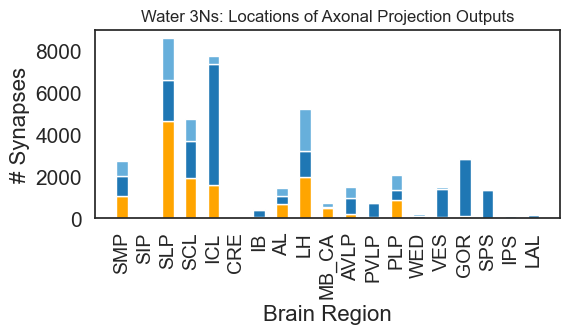

In [189]:
# Make bar graph showing outputs of water 3Ns, colored by NT

datasets = []
for category in categories:
    counts = pd.DataFrame(water3N_outputs[water3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and are barely visible in the graph
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Water 3Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [190]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/water3N_outputs[water3N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9060289304191743

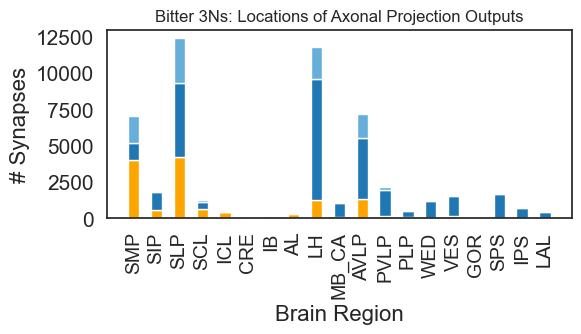

In [191]:
# Make bar graph showing outputs of bitter 2Ns, colored by NT

datasets = []
for category in categories:
    counts = pd.DataFrame(bitter3N_outputs[bitter3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and are barely visible in the graph
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Bitter 3Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [192]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/bitter3N_outputs[bitter3N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9969491975063006

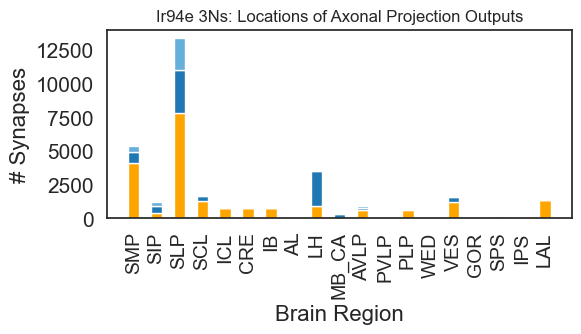

In [193]:
# Make bar graph showing outputs of lowsalt 2Ns, colored by NT

datasets = []
for category in categories:
    counts = pd.DataFrame(lowsalt3N_outputs[lowsalt3N_outputs['neuropil_remap'] == category])
    datasets.append(counts)

variables = count_NTs_brainregions(datasets, categories)

# We chose not to show "other" NTs because they represent only a tiny fraction and are barely visible in the graph
plt.figure(figsize=(6, 2.5))
plt.bar(categories, variables[0], color= 'orange', width = 0.5) #Ach
plt.bar(categories, variables[1], bottom = variables[0], color = '#1f77b4', width = 0.5) #GABA
plt.bar(categories, variables[2], bottom = variables[0]+variables[1], color = '#67afdb', width = 0.5) #Glut
#plt.bar(categories, variables[3], bottom = variables[0]+variables[1]+variables[2], color = 'grey', width = 0.5) # other NTs

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses',fontsize=16)
plt.title('Ir94e 3Ns: Locations of Axonal Projection Outputs')
#plt.legend(NTs)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [194]:
# Quantify how many of the projection synapses we're capturing
sum(sum(variables))/lowsalt3N_outputs[lowsalt3N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

0.9895419368332985

## 3g. Plotting net excitation onto each 3N

### We are quantifying net excitation onto each 3N from an individual modality
- Net excitation was already calculated above as the difference in the # of excitatory vs. inhibitory input synapses.
- In the plots, we are only including 3Ns that receive input from multiple 2Ns.

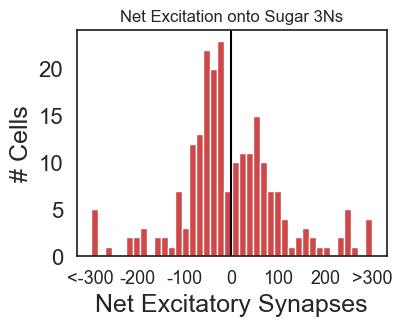

In [195]:
neurons_to_analyze = sugar_3Ns[sugar_3Ns['upstream_sugar_2Ns'] != 1] #exclude neurons receiving only one 2N input
sugar_net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

num_bins = 40
bins = np.linspace(-300, 301, num_bins + 1)
data = np.clip(sugar_net_excitation, bins[0], bins[-1])
sugar_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(4, 3))
plt.bar(bin_labels, sugar_frequencies, width=15, align='center', color='#cf4848')
plt.axvline(0, color='black')
bin_labels = np.arange(-300,301, 100)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '>300'
xlabels[0] = '<-300'
plt.xticks(ticks = 100 * np.arange(len(xlabels)) - 300, labels = xlabels, fontsize=13)
plt.yticks([0, 5, 10, 15, 20],fontsize=16)
plt.xlabel('Net Excitatory Synapses', fontsize=18)
plt.ylabel('# Cells', fontsize=18)
plt.title('Net Excitation onto Sugar 3Ns')
plt.show()

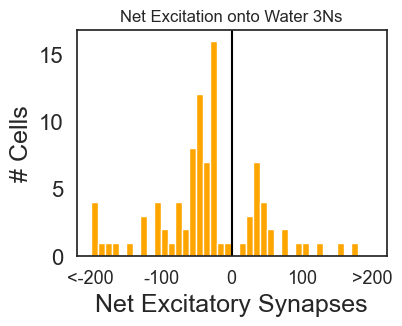

In [196]:
neurons_to_analyze = water_3Ns[water_3Ns['upstream_water_2Ns'] != 1] #exclude neurons receiving only one 2N input
water_net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

num_bins = 40
bins = np.linspace(-200, 200, num_bins + 1)
data = np.clip(water_net_excitation, bins[0], bins[-1])
water_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(4, 3))
plt.bar(bin_labels, water_frequencies, width=10, align='center', color='orange')
plt.axvline(0, color='black')
bin_labels = np.arange(-200,201, 100)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '>200'
xlabels[0] = '<-200'
plt.xticks(ticks = 100 * np.arange(len(xlabels)) - 200, labels = xlabels, fontsize=13)
plt.yticks([0, 5, 10, 15], fontsize=16)
plt.xlabel('Net Excitatory Synapses', fontsize=18)
plt.ylabel('# Cells', fontsize=18)
plt.title('Net Excitation onto Water 3Ns')
plt.show()


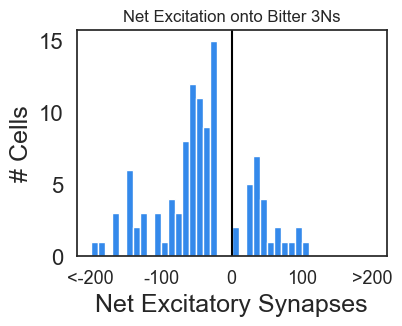

In [197]:
neurons_to_analyze = bitter_3Ns[bitter_3Ns['upstream_bitter_2Ns'] != 1] #exclude neurons receiving only one 2N input
bitter_net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

num_bins = 40
bins = np.linspace(-200, 200, num_bins + 1)
data = np.clip(bitter_net_excitation, bins[0], bins[-1])
bitter_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(4, 3))
plt.bar(bin_labels, bitter_frequencies, width=10, align='center', color='#3489eb')
plt.axvline(0, color='black')
bin_labels = np.arange(-200,201, 100)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '>200'
xlabels[0] = '<-200'
plt.xticks(ticks = 100 * np.arange(len(xlabels)) - 200, labels = xlabels, fontsize=13)
plt.yticks([0, 5, 10, 15], fontsize=16)
plt.xlabel('Net Excitatory Synapses', fontsize=18)
plt.ylabel('# Cells', fontsize=18)
plt.title('Net Excitation onto Bitter 3Ns')
plt.show()

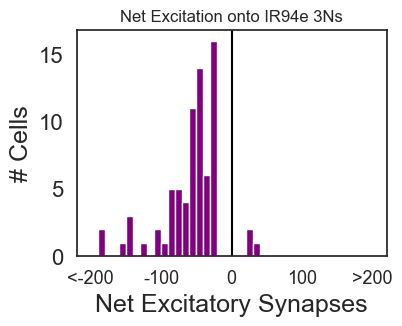

In [198]:
neurons_to_analyze = lowsalt_3Ns[lowsalt_3Ns['upstream_lowsalt_2Ns'] != 1] #exclude neurons receiving only one 2N input
lowsalt_net_excitation = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

num_bins = 40
bins = np.linspace(-200, 200, num_bins + 1)
data = np.clip(lowsalt_net_excitation, bins[0], bins[-1])
lowsalt_frequencies, bin_edges = np.histogram(data, bins)
bin_labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.figure(figsize=(4, 3))
plt.bar(bin_labels, lowsalt_frequencies, width=10, align='center', color='purple')
plt.axvline(0, color='black')
bin_labels = np.arange(-200,201, 100)
xlabels = np.array(bin_labels, dtype= str)
xlabels[-1] = '>200'
xlabels[0] = '<-200'
plt.xticks(ticks = 100 * np.arange(len(xlabels)) - 200, labels = xlabels, fontsize=13)
plt.yticks([0, 5, 10, 15], fontsize=16)
plt.xlabel('Net Excitatory Synapses', fontsize=18)
plt.ylabel('# Cells', fontsize=18)
plt.title('Net Excitation onto IR94e 3Ns')
plt.show()